<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [SYNOP2] - First predictions at 3h
<!-- DESC --> Episode 2 : RNN training session for weather prediction attempt at 3h
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Make a simple prediction (3h)
 - Understanding the use of a recurrent neural network


SYNOP meteorological data, available at: https://public.opendatasoft.com

## What we're going to do :

 - Read our dataset
 - Select our data and normalize it
 - Doing our training
 - Making simple predictions

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
import matplotlib.pyplot as plt

import pandas as pd
import h5py, json
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/SYNOP'
datasets_dir = pwk.init('SYNOP2', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.19
Notebook id          : SYNOP2
Run time             : Tuesday 09 March 2021, 22:35:52
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/SYNOP
Update keras cache   : False
Save figs            : True
Path figs            : ./run/SYNOP/figs


### 1.2 - Parameters

In [2]:
# ---- About dataset (no need to change)
#
dataset_dir      = './data'                  # Enhanced dataset is very small, so ./data in a good choice :-)
dataset_filename = 'synop-LYS.csv'
schema_filename  = 'synop.json'
features         = ['tend', 'cod_tend', 'dd', 'ff', 'td', 'u', 'ww', 'pres', 'rafper', 'rr1', 'rr3', 'tc']
features_len     = len(features)

# ---- About training (Can be changed !)
#
scale            = 1        # Percentage of dataset to be used (1=all)
train_prop       = .8       # Percentage for train (the rest being for the test)
sequence_len     = 16
batch_size       = 32
epochs           = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'train_prop', 'sequence_len', 'batch_size', 'epochs')

## Step 2 - Read and prepare dataset
### 2.1 - Read it

In [4]:
# ---- Read dataset from ./data

df = pd.read_csv(f'{dataset_dir}/{dataset_filename}', header=0, sep=';')

# ---- Scaling

df = df[:int(scale*len(df))]
train_len=int(train_prop*len(df))

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
pwk.subtitle('Train dataset example :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

pwk.subtitle('After normalization :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

pwk.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)


<br>**Train dataset example :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
0,-120.0,6.0,0.0,0.0,278.75,88.0,60.0,96250.0,4.1,0.0,0.0,7.5
1,-150.0,6.0,60.0,1.0,278.65,93.0,61.0,96100.0,2.6,0.2,0.6,6.6
2,10.0,3.0,280.0,2.1,278.85,95.0,58.0,96110.0,2.6,0.0,0.4,6.4
3,230.0,3.0,310.0,2.6,279.15,96.0,50.0,96340.0,5.7,0.0,3.0,6.6
4,280.0,1.0,330.0,4.6,278.15,94.0,21.0,96620.0,8.7,0.4,0.8,5.9
5,480.0,3.0,350.0,5.1,276.95,91.0,60.0,97100.0,8.2,0.2,0.4,5.2
6,530.0,2.0,350.0,3.1,274.05,83.0,21.0,97630.0,7.2,0.0,0.0,3.5
7,450.0,2.0,340.0,6.2,272.15,81.0,2.0,98080.0,9.3,0.0,0.0,1.9
8,280.0,1.0,320.0,6.2,270.15,74.0,2.0,98360.0,10.3,0.0,0.0,1.1
9,220.0,1.0,290.0,2.6,269.65,72.0,2.0,98580.0,5.1,0.0,0.0,1.0


<br>**After normalization :**

,tend,cod_tend,dd,ff,td,u,ww,pres,rafper,rr1,rr3,tc
count,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00,23332.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-6.79,-1.59,-1.74,-1.36,-5.22,-3.85,-0.53,-4.97,-1.62,-0.32,-0.27,-3.04
25%,-0.63,-0.85,-0.62,-0.75,-0.72,-0.68,-0.42,-0.55,-0.69,-0.16,-0.20,-0.75
50%,-0.00,-0.48,-0.11,-0.19,0.04,0.21,-0.42,0.04,-0.29,-0.16,-0.20,-0.01
75%,0.63,0.99,1.10,0.50,0.77,0.82,-0.37,0.62,0.51,-0.16,-0.20,0.71
max,7.14,1.36,1.35,6.24,2.44,1.59,4.45,3.08,6.25,29.82,31.17,3.07


<br>**Shapes :**

Dataset       :  (29165, 14)
Train dataset :  (23332, 12)
Test  dataset :  (5833, 12)


### 2.2 - Prepare data generator

In [5]:
# ---- Train generator
train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

pwk.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
pwk.subtitle('What a batch looks like (x) :')
pwk.np_print(x[0] )
pwk.subtitle('What a batch looks like (y) :')
pwk.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  729
batch x shape :  (32, 16, 12)
batch y shape :  (32, 12)


<br>**What a batch looks like (x) :**

[[-1.087  0.623 -1.743 -1.361 -0.212  0.928  2.554 -3.533 -0.555 -0.156 -0.199 -0.624]
 [-1.358  0.623 -1.227 -0.957 -0.229  1.206  2.605 -3.733 -0.946  0.17   0.219 -0.735]
 [ 0.089 -0.482  0.666 -0.512 -0.195  1.317  2.451 -3.72  -0.946 -0.156  0.08  -0.76 ]
 [ 2.079 -0.482  0.924 -0.31  -0.144  1.372  2.04  -3.413 -0.137 -0.156  1.892 -0.735]
 [ 2.531 -1.219  1.096  0.499 -0.313  1.261  0.552 -3.04   0.645  0.495  0.358 -0.821]
 [ 4.34  -0.482  1.268  0.701 -0.517  1.095  2.554 -2.401  0.515  0.17   0.08  -0.907]
 [ 4.792 -0.85   1.268 -0.107 -1.01   0.65   0.552 -1.694  0.254 -0.156 -0.199 -1.117]
 [ 4.069 -0.85   1.182  1.146 -1.333  0.539 -0.424 -1.094  0.802 -0.156 -0.199 -1.314]
 [ 2.531 -1.219  1.01   1.146 -1.673  0.15  -0.424 -0.721  1.063 -0.156 -0.199 -1.412]
 [ 1.988 -1.219  0.752 -0.31  -1.758  0.039 -0.424 -0.428 -0.294 -0.156 -0.199 -1.425]
 [ 0.903 -1.219  1.268 -0.107 -1.622  0.428 -0.424 -0.295 -0.555 -0.156 -0.199 -1.486]
 [ 2.712 -0.482  1.268  0.701 -1.944 -0.072

<br>**What a batch looks like (y) :**

[ 0.179 -1.219  0.58  -0.755 -2.063  0.65  -0.424  0.665 -1.233 -0.156 -0.199 -1.93 ]


## Step 3 - Create a model

In [6]:
model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.LSTM(100, activation='relu') )
model.add( keras.layers.Dropout(0.2) )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               45200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________


## Step 4 - Compile and train

### 4.1 - Callback

In [7]:
pwk.mkdir(run_dir)
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.2 - Compile

In [8]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics   = ['mae'] )

### 4.3 - Fit
6' with a CPU (laptop)  
2' with a GPU

In [9]:
pwk.chrono_start()

history=model.fit(train_generator, 
                  epochs=epochs, 
                  verbose=1,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

pwk.chrono_show()

Epoch 1/10


  1/729 [..............................] - ETA: 0s - loss: 0.7364 - mae: 0.6778

  4/729 [..............................] - ETA: 9s - loss: 0.8963 - mae: 0.7027

  7/729 [..............................] - ETA: 10s - loss: 1.1341 - mae: 0.7488

 11/729 [..............................] - ETA: 10s - loss: 1.0436 - mae: 0.7371

 15/729 [..............................] - ETA: 9s - loss: 0.9259 - mae: 0.7013 

 19/729 [..............................] - ETA: 9s - loss: 0.8821 - mae: 0.6889

 23/729 [..............................] - ETA: 9s - loss: 0.9174 - mae: 0.6970

 27/729 [>.............................] - ETA: 9s - loss: 0.9914 - mae: 0.6934

 31/729 [>.............................] - ETA: 9s - loss: 0.9765 - mae: 0.6928

 35/729 [>.............................] - ETA: 9s - loss: 0.9913 - mae: 0.6988

 39/729 [>.............................] - ETA: 9s - loss: 0.9518 - mae: 0.6900

 43/729 [>.............................] - ETA: 9s - loss: 0.9111 - mae: 0.6777

 47/729 [>.............................] - ETA: 9s - loss: 0.8887 - mae: 0.6724

 52/729 [=>............................] - ETA: 8s - loss: 0.8632 - mae: 0.6651

 57/729 [=>............................] - ETA: 8s - loss: 0.8352 - mae: 0.6555

 62/729 [=>............................] - ETA: 8s - loss: 0.8383 - mae: 0.6508

 67/729 [=>............................] - ETA: 8s - loss: 0.8221 - mae: 0.6443

 72/729 [=>............................] - ETA: 8s - loss: 0.8062 - mae: 0.6375

 77/729 [==>...........................] - ETA: 8s - loss: 0.7857 - mae: 0.6295

 82/729 [==>...........................] - ETA: 8s - loss: 0.8029 - mae: 0.6286

 87/729 [==>...........................] - ETA: 8s - loss: 0.7928 - mae: 0.6239

 92/729 [==>...........................] - ETA: 8s - loss: 0.7942 - mae: 0.6217

 97/729 [==>...........................] - ETA: 7s - loss: 0.7815 - mae: 0.6182

102/729 [===>..........................] - ETA: 7s - loss: 0.7745 - mae: 0.6157

107/729 [===>..........................] - ETA: 7s - loss: 0.8002 - mae: 0.6152

112/729 [===>..........................] - ETA: 7s - loss: 0.7972 - mae: 0.6129

117/729 [===>..........................] - ETA: 7s - loss: 0.7828 - mae: 0.6082

122/729 [====>.........................] - ETA: 7s - loss: 0.8097 - mae: 0.6080

127/729 [====>.........................] - ETA: 7s - loss: 0.7992 - mae: 0.6049

132/729 [====>.........................] - ETA: 7s - loss: 0.7877 - mae: 0.6009

137/729 [====>.........................] - ETA: 7s - loss: 0.7761 - mae: 0.5974

142/729 [====>.........................] - ETA: 7s - loss: 0.7647 - mae: 0.5936

147/729 [=====>........................] - ETA: 7s - loss: 0.7607 - mae: 0.5921

152/729 [=====>........................] - ETA: 7s - loss: 0.7548 - mae: 0.5900

157/729 [=====>........................] - ETA: 7s - loss: 0.7486 - mae: 0.5875

162/729 [=====>........................] - ETA: 6s - loss: 0.7424 - mae: 0.5856

167/729 [=====>........................] - ETA: 6s - loss: 0.7409 - mae: 0.5843

172/729 [======>.......................] - ETA: 6s - loss: 0.7349 - mae: 0.5827

177/729 [======>.......................] - ETA: 6s - loss: 0.7289 - mae: 0.5805

182/729 [======>.......................] - ETA: 6s - loss: 0.7253 - mae: 0.5787

187/729 [======>.......................] - ETA: 6s - loss: 0.7208 - mae: 0.5773

192/729 [======>.......................] - ETA: 6s - loss: 0.7133 - mae: 0.5751

197/729 [=======>......................] - ETA: 6s - loss: 0.7075 - mae: 0.5732

202/729 [=======>......................] - ETA: 6s - loss: 0.7087 - mae: 0.5738

207/729 [=======>......................] - ETA: 6s - loss: 0.7028 - mae: 0.5717

212/729 [=======>......................] - ETA: 6s - loss: 0.6972 - mae: 0.5696

217/729 [=======>......................] - ETA: 6s - loss: 0.6949 - mae: 0.5693

222/729 [========>.....................] - ETA: 6s - loss: 0.7006 - mae: 0.5682

227/729 [========>.....................] - ETA: 6s - loss: 0.6969 - mae: 0.5669

232/729 [========>.....................] - ETA: 6s - loss: 0.6930 - mae: 0.5654

236/729 [========>.....................] - ETA: 6s - loss: 0.6889 - mae: 0.5640

240/729 [========>.....................] - ETA: 5s - loss: 0.6846 - mae: 0.5625

244/729 [=========>....................] - ETA: 5s - loss: 0.6819 - mae: 0.5612

248/729 [=========>....................] - ETA: 5s - loss: 0.6841 - mae: 0.5613

252/729 [=========>....................] - ETA: 5s - loss: 0.6816 - mae: 0.5603

256/729 [=========>....................] - ETA: 5s - loss: 0.6777 - mae: 0.5586

260/729 [=========>....................] - ETA: 5s - loss: 0.6763 - mae: 0.5578

264/729 [=========>....................] - ETA: 5s - loss: 0.6731 - mae: 0.5567

268/729 [==========>...................] - ETA: 5s - loss: 0.6723 - mae: 0.5567

272/729 [==========>...................] - ETA: 5s - loss: 0.6701 - mae: 0.5556

276/729 [==========>...................] - ETA: 5s - loss: 0.6688 - mae: 0.5547

280/729 [==========>...................] - ETA: 5s - loss: 0.6736 - mae: 0.5551

284/729 [==========>...................] - ETA: 5s - loss: 0.6704 - mae: 0.5539

288/729 [==========>...................] - ETA: 5s - loss: 0.6676 - mae: 0.5525

292/729 [===========>..................] - ETA: 5s - loss: 0.6644 - mae: 0.5516

296/729 [===========>..................] - ETA: 5s - loss: 0.6615 - mae: 0.5505

300/729 [===========>..................] - ETA: 5s - loss: 0.6587 - mae: 0.5494

304/729 [===========>..................] - ETA: 5s - loss: 0.6574 - mae: 0.5490

308/729 [===========>..................] - ETA: 5s - loss: 0.6557 - mae: 0.5482

312/729 [===========>..................] - ETA: 5s - loss: 0.6539 - mae: 0.5476

316/729 [============>.................] - ETA: 5s - loss: 0.6508 - mae: 0.5463

320/729 [============>.................] - ETA: 5s - loss: 0.6490 - mae: 0.5456

324/729 [============>.................] - ETA: 5s - loss: 0.6558 - mae: 0.5460

328/729 [============>.................] - ETA: 5s - loss: 0.6607 - mae: 0.5464

332/729 [============>.................] - ETA: 5s - loss: 0.6657 - mae: 0.5468

336/729 [============>.................] - ETA: 5s - loss: 0.6750 - mae: 0.5477

340/729 [============>.................] - ETA: 5s - loss: 0.6785 - mae: 0.5485

344/729 [=============>................] - ETA: 4s - loss: 0.6764 - mae: 0.5482

348/729 [=============>................] - ETA: 4s - loss: 0.6762 - mae: 0.5481

352/729 [=============>................] - ETA: 4s - loss: 0.6751 - mae: 0.5478

356/729 [=============>................] - ETA: 4s - loss: 0.6724 - mae: 0.5468

360/729 [=============>................] - ETA: 4s - loss: 0.6686 - mae: 0.5453

364/729 [=============>................] - ETA: 4s - loss: 0.6673 - mae: 0.5449

368/729 [==============>...............] - ETA: 4s - loss: 0.6652 - mae: 0.5441

372/729 [==============>...............] - ETA: 4s - loss: 0.6631 - mae: 0.5434

376/729 [==============>...............] - ETA: 4s - loss: 0.6604 - mae: 0.5423

380/729 [==============>...............] - ETA: 4s - loss: 0.6581 - mae: 0.5417

384/729 [==============>...............] - ETA: 4s - loss: 0.6585 - mae: 0.5417

388/729 [==============>...............] - ETA: 4s - loss: 0.6565 - mae: 0.5411

392/729 [===============>..............] - ETA: 4s - loss: 0.6577 - mae: 0.5408

396/729 [===============>..............] - ETA: 4s - loss: 0.6552 - mae: 0.5398

400/729 [===============>..............] - ETA: 4s - loss: 0.6531 - mae: 0.5390

404/729 [===============>..............] - ETA: 4s - loss: 0.6501 - mae: 0.5378

408/729 [===============>..............] - ETA: 4s - loss: 0.6476 - mae: 0.5369

412/729 [===============>..............] - ETA: 4s - loss: 0.6469 - mae: 0.5364

416/729 [================>.............] - ETA: 4s - loss: 0.6516 - mae: 0.5359

420/729 [================>.............] - ETA: 4s - loss: 0.6567 - mae: 0.5359

424/729 [================>.............] - ETA: 4s - loss: 0.6553 - mae: 0.5357

428/729 [================>.............] - ETA: 3s - loss: 0.6590 - mae: 0.5358

432/729 [================>.............] - ETA: 3s - loss: 0.6582 - mae: 0.5353

436/729 [================>.............] - ETA: 3s - loss: 0.6595 - mae: 0.5356

440/729 [=================>............] - ETA: 3s - loss: 0.6591 - mae: 0.5353

444/729 [=================>............] - ETA: 3s - loss: 0.6565 - mae: 0.5344

448/729 [=================>............] - ETA: 3s - loss: 0.6545 - mae: 0.5339

452/729 [=================>............] - ETA: 3s - loss: 0.6533 - mae: 0.5336

456/729 [=================>............] - ETA: 3s - loss: 0.6518 - mae: 0.5331

460/729 [=================>............] - ETA: 3s - loss: 0.6496 - mae: 0.5323

464/729 [==================>...........] - ETA: 3s - loss: 0.6492 - mae: 0.5322

467/729 [==================>...........] - ETA: 3s - loss: 0.6481 - mae: 0.5318

471/729 [==================>...........] - ETA: 3s - loss: 0.6460 - mae: 0.5312

475/729 [==================>...........] - ETA: 3s - loss: 0.6442 - mae: 0.5306

479/729 [==================>...........] - ETA: 3s - loss: 0.6429 - mae: 0.5303

483/729 [==================>...........] - ETA: 3s - loss: 0.6414 - mae: 0.5298

487/729 [===================>..........] - ETA: 3s - loss: 0.6391 - mae: 0.5288

491/729 [===================>..........] - ETA: 3s - loss: 0.6392 - mae: 0.5284

495/729 [===================>..........] - ETA: 3s - loss: 0.6379 - mae: 0.5280

499/729 [===================>..........] - ETA: 3s - loss: 0.6368 - mae: 0.5276

503/729 [===================>..........] - ETA: 3s - loss: 0.6354 - mae: 0.5270

507/729 [===================>..........] - ETA: 2s - loss: 0.6345 - mae: 0.5267

511/729 [====================>.........] - ETA: 2s - loss: 0.6345 - mae: 0.5269

515/729 [====================>.........] - ETA: 2s - loss: 0.6372 - mae: 0.5266

519/729 [====================>.........] - ETA: 2s - loss: 0.6349 - mae: 0.5257

523/729 [====================>.........] - ETA: 2s - loss: 0.6366 - mae: 0.5257

527/729 [====================>.........] - ETA: 2s - loss: 0.6365 - mae: 0.5255

531/729 [====================>.........] - ETA: 2s - loss: 0.6363 - mae: 0.5255

535/729 [=====================>........] - ETA: 2s - loss: 0.6353 - mae: 0.5252

539/729 [=====================>........] - ETA: 2s - loss: 0.6343 - mae: 0.5250

543/729 [=====================>........] - ETA: 2s - loss: 0.6334 - mae: 0.5247

547/729 [=====================>........] - ETA: 2s - loss: 0.6403 - mae: 0.5257

551/729 [=====================>........] - ETA: 2s - loss: 0.6425 - mae: 0.5254

555/729 [=====================>........] - ETA: 2s - loss: 0.6408 - mae: 0.5251

559/729 [======================>.......] - ETA: 2s - loss: 0.6400 - mae: 0.5249

563/729 [======================>.......] - ETA: 2s - loss: 0.6387 - mae: 0.5246

567/729 [======================>.......] - ETA: 2s - loss: 0.6375 - mae: 0.5243

571/729 [======================>.......] - ETA: 2s - loss: 0.6374 - mae: 0.5239

575/729 [======================>.......] - ETA: 2s - loss: 0.6371 - mae: 0.5235

579/729 [======================>.......] - ETA: 2s - loss: 0.6352 - mae: 0.5227

583/729 [======================>.......] - ETA: 1s - loss: 0.6348 - mae: 0.5224

587/729 [=======================>......] - ETA: 1s - loss: 0.6338 - mae: 0.5220

591/729 [=======================>......] - ETA: 1s - loss: 0.6320 - mae: 0.5214

595/729 [=======================>......] - ETA: 1s - loss: 0.6311 - mae: 0.5210

599/729 [=======================>......] - ETA: 1s - loss: 0.6305 - mae: 0.5208

603/729 [=======================>......] - ETA: 1s - loss: 0.6296 - mae: 0.5205

607/729 [=======================>......] - ETA: 1s - loss: 0.6282 - mae: 0.5201

611/729 [========================>.....] - ETA: 1s - loss: 0.6266 - mae: 0.5195

615/729 [========================>.....] - ETA: 1s - loss: 0.6324 - mae: 0.5198

619/729 [========================>.....] - ETA: 1s - loss: 0.6313 - mae: 0.5195

623/729 [========================>.....] - ETA: 1s - loss: 0.6297 - mae: 0.5191

627/729 [========================>.....] - ETA: 1s - loss: 0.6290 - mae: 0.5188

631/729 [========================>.....] - ETA: 1s - loss: 0.6271 - mae: 0.5181

635/729 [=========================>....] - ETA: 1s - loss: 0.6251 - mae: 0.5173

639/729 [=========================>....] - ETA: 1s - loss: 0.6238 - mae: 0.5167

643/729 [=========================>....] - ETA: 1s - loss: 0.6219 - mae: 0.5159

647/729 [=========================>....] - ETA: 1s - loss: 0.6207 - mae: 0.5155

651/729 [=========================>....] - ETA: 1s - loss: 0.6197 - mae: 0.5150

655/729 [=========================>....] - ETA: 1s - loss: 0.6186 - mae: 0.5147

659/729 [==========================>...] - ETA: 0s - loss: 0.6172 - mae: 0.5142

663/729 [==========================>...] - ETA: 0s - loss: 0.6177 - mae: 0.5143

667/729 [==========================>...] - ETA: 0s - loss: 0.6169 - mae: 0.5139

671/729 [==========================>...] - ETA: 0s - loss: 0.6165 - mae: 0.5138

675/729 [==========================>...] - ETA: 0s - loss: 0.6166 - mae: 0.5137

679/729 [==========================>...] - ETA: 0s - loss: 0.6156 - mae: 0.5134

683/729 [===========================>..] - ETA: 0s - loss: 0.6146 - mae: 0.5130

687/729 [===========================>..] - ETA: 0s - loss: 0.6139 - mae: 0.5126

691/729 [===========================>..] - ETA: 0s - loss: 0.6128 - mae: 0.5122

695/729 [===========================>..] - ETA: 0s - loss: 0.6114 - mae: 0.5117

699/729 [===========================>..] - ETA: 0s - loss: 0.6104 - mae: 0.5113

703/729 [===========================>..] - ETA: 0s - loss: 0.6092 - mae: 0.5108

707/729 [============================>.] - ETA: 0s - loss: 0.6085 - mae: 0.5104

711/729 [============================>.] - ETA: 0s - loss: 0.6071 - mae: 0.5097

715/729 [============================>.] - ETA: 0s - loss: 0.6062 - mae: 0.5094

719/729 [============================>.] - ETA: 0s - loss: 0.6059 - mae: 0.5090

723/729 [============================>.] - ETA: 0s - loss: 0.6046 - mae: 0.5085

727/729 [============================>.] - ETA: 0s - loss: 0.6033 - mae: 0.5080

729/729 [==============================] - 11s 16ms/step - loss: 0.6027 - mae: 0.5078 - val_loss: 0.4866 - val_mae: 0.4223


Epoch 2/10
  1/729 [..............................] - ETA: 0s - loss: 0.4111 - mae: 0.4386

  5/729 [..............................] - ETA: 8s - loss: 0.4623 - mae: 0.4563

  9/729 [..............................] - ETA: 9s - loss: 0.5709 - mae: 0.4552

 13/729 [..............................] - ETA: 9s - loss: 0.5252 - mae: 0.4509

 17/729 [..............................] - ETA: 10s - loss: 0.5143 - mae: 0.4549

 21/729 [..............................] - ETA: 10s - loss: 0.4855 - mae: 0.4474

 25/729 [>.............................] - ETA: 10s - loss: 0.4601 - mae: 0.4388

 29/729 [>.............................] - ETA: 10s - loss: 0.4983 - mae: 0.4446

 33/729 [>.............................] - ETA: 10s - loss: 0.4883 - mae: 0.4440

 37/729 [>.............................] - ETA: 10s - loss: 0.4909 - mae: 0.4471

 41/729 [>.............................] - ETA: 10s - loss: 0.4811 - mae: 0.4457

 44/729 [>.............................] - ETA: 10s - loss: 0.4765 - mae: 0.4450

 47/729 [>.............................] - ETA: 10s - loss: 0.4840 - mae: 0.4477

 51/729 [=>............................] - ETA: 10s - loss: 0.4836 - mae: 0.4459

 55/729 [=>............................] - ETA: 10s - loss: 0.4837 - mae: 0.4457

 59/729 [=>............................] - ETA: 10s - loss: 0.4791 - mae: 0.4459

 63/729 [=>............................] - ETA: 10s - loss: 0.4752 - mae: 0.4448

 67/729 [=>............................] - ETA: 10s - loss: 0.4937 - mae: 0.4481

 71/729 [=>............................] - ETA: 9s - loss: 0.4913 - mae: 0.4476 

 75/729 [==>...........................] - ETA: 9s - loss: 0.4849 - mae: 0.4466

 79/729 [==>...........................] - ETA: 9s - loss: 0.4810 - mae: 0.4452

 83/729 [==>...........................] - ETA: 9s - loss: 0.4764 - mae: 0.4434

 87/729 [==>...........................] - ETA: 9s - loss: 0.4731 - mae: 0.4422

 91/729 [==>...........................] - ETA: 9s - loss: 0.5167 - mae: 0.4450

 95/729 [==>...........................] - ETA: 9s - loss: 0.5126 - mae: 0.4447

 99/729 [===>..........................] - ETA: 9s - loss: 0.5131 - mae: 0.4465

103/729 [===>..........................] - ETA: 9s - loss: 0.5068 - mae: 0.4450

107/729 [===>..........................] - ETA: 9s - loss: 0.5049 - mae: 0.4450

111/729 [===>..........................] - ETA: 9s - loss: 0.4965 - mae: 0.4421

115/729 [===>..........................] - ETA: 9s - loss: 0.4938 - mae: 0.4420

119/729 [===>..........................] - ETA: 9s - loss: 0.4904 - mae: 0.4412

123/729 [====>.........................] - ETA: 8s - loss: 0.4892 - mae: 0.4415

127/729 [====>.........................] - ETA: 8s - loss: 0.4908 - mae: 0.4435

131/729 [====>.........................] - ETA: 8s - loss: 0.4921 - mae: 0.4449

135/729 [====>.........................] - ETA: 8s - loss: 0.4923 - mae: 0.4457

139/729 [====>.........................] - ETA: 8s - loss: 0.4970 - mae: 0.4462

143/729 [====>.........................] - ETA: 8s - loss: 0.4964 - mae: 0.4461

147/729 [=====>........................] - ETA: 8s - loss: 0.4922 - mae: 0.4452

151/729 [=====>........................] - ETA: 8s - loss: 0.4949 - mae: 0.4467

155/729 [=====>........................] - ETA: 8s - loss: 0.4945 - mae: 0.4467

159/729 [=====>........................] - ETA: 8s - loss: 0.4983 - mae: 0.4465

163/729 [=====>........................] - ETA: 8s - loss: 0.4938 - mae: 0.4451

167/729 [=====>........................] - ETA: 8s - loss: 0.4952 - mae: 0.4463

171/729 [======>.......................] - ETA: 8s - loss: 0.4994 - mae: 0.4470

175/729 [======>.......................] - ETA: 8s - loss: 0.4985 - mae: 0.4472

179/729 [======>.......................] - ETA: 8s - loss: 0.4970 - mae: 0.4469

183/729 [======>.......................] - ETA: 8s - loss: 0.4977 - mae: 0.4470

187/729 [======>.......................] - ETA: 8s - loss: 0.4976 - mae: 0.4473

190/729 [======>.......................] - ETA: 8s - loss: 0.4974 - mae: 0.4479

194/729 [======>.......................] - ETA: 8s - loss: 0.4965 - mae: 0.4474

198/729 [=======>......................] - ETA: 7s - loss: 0.4923 - mae: 0.4457

202/729 [=======>......................] - ETA: 7s - loss: 0.4938 - mae: 0.4460

206/729 [=======>......................] - ETA: 7s - loss: 0.5005 - mae: 0.4465

210/729 [=======>......................] - ETA: 7s - loss: 0.4987 - mae: 0.4458

214/729 [=======>......................] - ETA: 7s - loss: 0.4975 - mae: 0.4460

218/729 [=======>......................] - ETA: 7s - loss: 0.4986 - mae: 0.4469

222/729 [========>.....................] - ETA: 7s - loss: 0.4972 - mae: 0.4470

226/729 [========>.....................] - ETA: 7s - loss: 0.4950 - mae: 0.4466

230/729 [========>.....................] - ETA: 7s - loss: 0.4955 - mae: 0.4469

234/729 [========>.....................] - ETA: 7s - loss: 0.4949 - mae: 0.4467

238/729 [========>.....................] - ETA: 7s - loss: 0.4932 - mae: 0.4465

242/729 [========>.....................] - ETA: 7s - loss: 0.4999 - mae: 0.4468

246/729 [=========>....................] - ETA: 7s - loss: 0.5006 - mae: 0.4475

250/729 [=========>....................] - ETA: 7s - loss: 0.4996 - mae: 0.4471

254/729 [=========>....................] - ETA: 7s - loss: 0.4975 - mae: 0.4467

258/729 [=========>....................] - ETA: 7s - loss: 0.4961 - mae: 0.4462

262/729 [=========>....................] - ETA: 7s - loss: 0.4955 - mae: 0.4463

266/729 [=========>....................] - ETA: 6s - loss: 0.4947 - mae: 0.4462

270/729 [==========>...................] - ETA: 6s - loss: 0.4955 - mae: 0.4464

274/729 [==========>...................] - ETA: 6s - loss: 0.4939 - mae: 0.4460

278/729 [==========>...................] - ETA: 6s - loss: 0.4963 - mae: 0.4463

282/729 [==========>...................] - ETA: 6s - loss: 0.4957 - mae: 0.4462

286/729 [==========>...................] - ETA: 6s - loss: 0.4945 - mae: 0.4458

290/729 [==========>...................] - ETA: 6s - loss: 0.4934 - mae: 0.4458

294/729 [===========>..................] - ETA: 6s - loss: 0.4921 - mae: 0.4454

298/729 [===========>..................] - ETA: 6s - loss: 0.4912 - mae: 0.4451

302/729 [===========>..................] - ETA: 6s - loss: 0.4915 - mae: 0.4452

306/729 [===========>..................] - ETA: 6s - loss: 0.4909 - mae: 0.4452

310/729 [===========>..................] - ETA: 6s - loss: 0.4887 - mae: 0.4444

314/729 [===========>..................] - ETA: 6s - loss: 0.4895 - mae: 0.4441

318/729 [============>.................] - ETA: 6s - loss: 0.4907 - mae: 0.4442

322/729 [============>.................] - ETA: 6s - loss: 0.4899 - mae: 0.4437

326/729 [============>.................] - ETA: 6s - loss: 0.4889 - mae: 0.4434

330/729 [============>.................] - ETA: 6s - loss: 0.4923 - mae: 0.4440

334/729 [============>.................] - ETA: 5s - loss: 0.4919 - mae: 0.4439

338/729 [============>.................] - ETA: 5s - loss: 0.4902 - mae: 0.4435

342/729 [=============>................] - ETA: 5s - loss: 0.4893 - mae: 0.4432

346/729 [=============>................] - ETA: 5s - loss: 0.4873 - mae: 0.4425

350/729 [=============>................] - ETA: 5s - loss: 0.4863 - mae: 0.4423

354/729 [=============>................] - ETA: 5s - loss: 0.4857 - mae: 0.4422

358/729 [=============>................] - ETA: 5s - loss: 0.4850 - mae: 0.4420

362/729 [=============>................] - ETA: 5s - loss: 0.4839 - mae: 0.4418

366/729 [==============>...............] - ETA: 5s - loss: 0.4846 - mae: 0.4419

370/729 [==============>...............] - ETA: 5s - loss: 0.4839 - mae: 0.4418

374/729 [==============>...............] - ETA: 5s - loss: 0.4842 - mae: 0.4419

378/729 [==============>...............] - ETA: 5s - loss: 0.4833 - mae: 0.4416

382/729 [==============>...............] - ETA: 5s - loss: 0.4819 - mae: 0.4412

386/729 [==============>...............] - ETA: 5s - loss: 0.4812 - mae: 0.4409

390/729 [===============>..............] - ETA: 5s - loss: 0.4807 - mae: 0.4407

394/729 [===============>..............] - ETA: 5s - loss: 0.4815 - mae: 0.4410

398/729 [===============>..............] - ETA: 5s - loss: 0.4801 - mae: 0.4405

402/729 [===============>..............] - ETA: 4s - loss: 0.4799 - mae: 0.4405

406/729 [===============>..............] - ETA: 4s - loss: 0.4808 - mae: 0.4411

410/729 [===============>..............] - ETA: 4s - loss: 0.4891 - mae: 0.4412

414/729 [================>.............] - ETA: 4s - loss: 0.4890 - mae: 0.4410

418/729 [================>.............] - ETA: 4s - loss: 0.4892 - mae: 0.4415

422/729 [================>.............] - ETA: 4s - loss: 0.4894 - mae: 0.4417

426/729 [================>.............] - ETA: 4s - loss: 0.4898 - mae: 0.4421

430/729 [================>.............] - ETA: 4s - loss: 0.4888 - mae: 0.4418

434/729 [================>.............] - ETA: 4s - loss: 0.4944 - mae: 0.4422

438/729 [=================>............] - ETA: 4s - loss: 0.4952 - mae: 0.4427

442/729 [=================>............] - ETA: 4s - loss: 0.4951 - mae: 0.4429

446/729 [=================>............] - ETA: 4s - loss: 0.4980 - mae: 0.4431

450/729 [=================>............] - ETA: 4s - loss: 0.4982 - mae: 0.4431

454/729 [=================>............] - ETA: 4s - loss: 0.4980 - mae: 0.4431

458/729 [=================>............] - ETA: 4s - loss: 0.4976 - mae: 0.4430

462/729 [==================>...........] - ETA: 4s - loss: 0.4978 - mae: 0.4433

466/729 [==================>...........] - ETA: 3s - loss: 0.4973 - mae: 0.4432

470/729 [==================>...........] - ETA: 3s - loss: 0.4971 - mae: 0.4433

474/729 [==================>...........] - ETA: 3s - loss: 0.4988 - mae: 0.4439

478/729 [==================>...........] - ETA: 3s - loss: 0.4974 - mae: 0.4435

482/729 [==================>...........] - ETA: 3s - loss: 0.4963 - mae: 0.4433

485/729 [==================>...........] - ETA: 3s - loss: 0.5014 - mae: 0.4437

488/729 [===================>..........] - ETA: 3s - loss: 0.5011 - mae: 0.4436

491/729 [===================>..........] - ETA: 3s - loss: 0.5045 - mae: 0.4436

494/729 [===================>..........] - ETA: 3s - loss: 0.5051 - mae: 0.4440

497/729 [===================>..........] - ETA: 3s - loss: 0.5046 - mae: 0.4439

500/729 [===================>..........] - ETA: 3s - loss: 0.5067 - mae: 0.4441

503/729 [===================>..........] - ETA: 3s - loss: 0.5074 - mae: 0.4443

506/729 [===================>..........] - ETA: 3s - loss: 0.5069 - mae: 0.4444

510/729 [===================>..........] - ETA: 3s - loss: 0.5093 - mae: 0.4451

514/729 [====================>.........] - ETA: 3s - loss: 0.5075 - mae: 0.4445

517/729 [====================>.........] - ETA: 3s - loss: 0.5068 - mae: 0.4444

521/729 [====================>.........] - ETA: 3s - loss: 0.5081 - mae: 0.4445

525/729 [====================>.........] - ETA: 3s - loss: 0.5102 - mae: 0.4446

529/729 [====================>.........] - ETA: 3s - loss: 0.5100 - mae: 0.4446

533/729 [====================>.........] - ETA: 2s - loss: 0.5085 - mae: 0.4442

537/729 [=====================>........] - ETA: 2s - loss: 0.5076 - mae: 0.4440

541/729 [=====================>........] - ETA: 2s - loss: 0.5063 - mae: 0.4435

545/729 [=====================>........] - ETA: 2s - loss: 0.5054 - mae: 0.4432

549/729 [=====================>........] - ETA: 2s - loss: 0.5051 - mae: 0.4432

553/729 [=====================>........] - ETA: 2s - loss: 0.5041 - mae: 0.4431

557/729 [=====================>........] - ETA: 2s - loss: 0.5031 - mae: 0.4429

561/729 [======================>.......] - ETA: 2s - loss: 0.5026 - mae: 0.4429

565/729 [======================>.......] - ETA: 2s - loss: 0.5015 - mae: 0.4425

569/729 [======================>.......] - ETA: 2s - loss: 0.5003 - mae: 0.4421

573/729 [======================>.......] - ETA: 2s - loss: 0.5001 - mae: 0.4419

577/729 [======================>.......] - ETA: 2s - loss: 0.5005 - mae: 0.4419

581/729 [======================>.......] - ETA: 2s - loss: 0.5048 - mae: 0.4420

585/729 [=======================>......] - ETA: 2s - loss: 0.5043 - mae: 0.4420

589/729 [=======================>......] - ETA: 2s - loss: 0.5061 - mae: 0.4423

593/729 [=======================>......] - ETA: 2s - loss: 0.5058 - mae: 0.4425

597/729 [=======================>......] - ETA: 2s - loss: 0.5099 - mae: 0.4432

601/729 [=======================>......] - ETA: 1s - loss: 0.5105 - mae: 0.4432

605/729 [=======================>......] - ETA: 1s - loss: 0.5097 - mae: 0.4431

609/729 [========================>.....] - ETA: 1s - loss: 0.5089 - mae: 0.4429

613/729 [========================>.....] - ETA: 1s - loss: 0.5079 - mae: 0.4427

617/729 [========================>.....] - ETA: 1s - loss: 0.5076 - mae: 0.4427

621/729 [========================>.....] - ETA: 1s - loss: 0.5069 - mae: 0.4426

625/729 [========================>.....] - ETA: 1s - loss: 0.5061 - mae: 0.4424

629/729 [========================>.....] - ETA: 1s - loss: 0.5064 - mae: 0.4427

633/729 [=========================>....] - ETA: 1s - loss: 0.5050 - mae: 0.4423

637/729 [=========================>....] - ETA: 1s - loss: 0.5045 - mae: 0.4422

641/729 [=========================>....] - ETA: 1s - loss: 0.5035 - mae: 0.4421

645/729 [=========================>....] - ETA: 1s - loss: 0.5035 - mae: 0.4422

649/729 [=========================>....] - ETA: 1s - loss: 0.5063 - mae: 0.4422

653/729 [=========================>....] - ETA: 1s - loss: 0.5052 - mae: 0.4419

657/729 [==========================>...] - ETA: 1s - loss: 0.5055 - mae: 0.4418

661/729 [==========================>...] - ETA: 1s - loss: 0.5058 - mae: 0.4420

665/729 [==========================>...] - ETA: 0s - loss: 0.5062 - mae: 0.4422

669/729 [==========================>...] - ETA: 0s - loss: 0.5057 - mae: 0.4421

673/729 [==========================>...] - ETA: 0s - loss: 0.5048 - mae: 0.4419

677/729 [==========================>...] - ETA: 0s - loss: 0.5051 - mae: 0.4418

681/729 [===========================>..] - ETA: 0s - loss: 0.5044 - mae: 0.4416

685/729 [===========================>..] - ETA: 0s - loss: 0.5065 - mae: 0.4423

689/729 [===========================>..] - ETA: 0s - loss: 0.5060 - mae: 0.4423

693/729 [===========================>..] - ETA: 0s - loss: 0.5051 - mae: 0.4420

697/729 [===========================>..] - ETA: 0s - loss: 0.5092 - mae: 0.4425

701/729 [===========================>..] - ETA: 0s - loss: 0.5085 - mae: 0.4423

705/729 [============================>.] - ETA: 0s - loss: 0.5075 - mae: 0.4420

709/729 [============================>.] - ETA: 0s - loss: 0.5067 - mae: 0.4418

713/729 [============================>.] - ETA: 0s - loss: 0.5060 - mae: 0.4416

717/729 [============================>.] - ETA: 0s - loss: 0.5057 - mae: 0.4415

721/729 [============================>.] - ETA: 0s - loss: 0.5051 - mae: 0.4414

725/729 [============================>.] - ETA: 0s - loss: 0.5082 - mae: 0.4413

729/729 [==============================] - ETA: 0s - loss: 0.5075 - mae: 0.4412

729/729 [==============================] - 12s 17ms/step - loss: 0.5075 - mae: 0.4412 - val_loss: 0.4676 - val_mae: 0.4079


Epoch 3/10
  1/729 [..............................] - ETA: 0s - loss: 0.3293 - mae: 0.3903

  5/729 [..............................] - ETA: 9s - loss: 0.3410 - mae: 0.3884

  9/729 [..............................] - ETA: 9s - loss: 0.3518 - mae: 0.3944

 13/729 [..............................] - ETA: 10s - loss: 0.4960 - mae: 0.4291

 17/729 [..............................] - ETA: 10s - loss: 0.5091 - mae: 0.4396

 21/729 [..............................] - ETA: 10s - loss: 0.4844 - mae: 0.4323

 25/729 [>.............................] - ETA: 10s - loss: 0.5344 - mae: 0.4445

 29/729 [>.............................] - ETA: 10s - loss: 0.5815 - mae: 0.4553

 32/729 [>.............................] - ETA: 10s - loss: 0.5554 - mae: 0.4486

 35/729 [>.............................] - ETA: 10s - loss: 0.5466 - mae: 0.4496

 38/729 [>.............................] - ETA: 10s - loss: 0.5443 - mae: 0.4503

 42/729 [>.............................] - ETA: 10s - loss: 0.5317 - mae: 0.4469

 46/729 [>.............................] - ETA: 10s - loss: 0.5110 - mae: 0.4395

 49/729 [=>............................] - ETA: 10s - loss: 0.4986 - mae: 0.4358

 52/729 [=>............................] - ETA: 10s - loss: 0.4970 - mae: 0.4375

 55/729 [=>............................] - ETA: 10s - loss: 0.4843 - mae: 0.4328

 58/729 [=>............................] - ETA: 10s - loss: 0.4793 - mae: 0.4323

 62/729 [=>............................] - ETA: 10s - loss: 0.4753 - mae: 0.4311

 66/729 [=>............................] - ETA: 10s - loss: 0.4684 - mae: 0.4291

 70/729 [=>............................] - ETA: 10s - loss: 0.4675 - mae: 0.4309

 74/729 [==>...........................] - ETA: 10s - loss: 0.4679 - mae: 0.4311

 78/729 [==>...........................] - ETA: 10s - loss: 0.4634 - mae: 0.4296

 82/729 [==>...........................] - ETA: 10s - loss: 0.4575 - mae: 0.4274

 86/729 [==>...........................] - ETA: 10s - loss: 0.4534 - mae: 0.4257

 90/729 [==>...........................] - ETA: 10s - loss: 0.4554 - mae: 0.4256

 94/729 [==>...........................] - ETA: 9s - loss: 0.4547 - mae: 0.4255 

 98/729 [===>..........................] - ETA: 9s - loss: 0.4618 - mae: 0.4267

102/729 [===>..........................] - ETA: 9s - loss: 0.4578 - mae: 0.4256

105/729 [===>..........................] - ETA: 9s - loss: 0.4565 - mae: 0.4258

109/729 [===>..........................] - ETA: 9s - loss: 0.4719 - mae: 0.4256

113/729 [===>..........................] - ETA: 9s - loss: 0.4679 - mae: 0.4246

117/729 [===>..........................] - ETA: 9s - loss: 0.4681 - mae: 0.4253

121/729 [===>..........................] - ETA: 9s - loss: 0.4639 - mae: 0.4245

125/729 [====>.........................] - ETA: 9s - loss: 0.4593 - mae: 0.4230

129/729 [====>.........................] - ETA: 9s - loss: 0.4583 - mae: 0.4232

133/729 [====>.........................] - ETA: 9s - loss: 0.4610 - mae: 0.4253

137/729 [====>.........................] - ETA: 9s - loss: 0.4696 - mae: 0.4276

141/729 [====>.........................] - ETA: 9s - loss: 0.4668 - mae: 0.4273

145/729 [====>.........................] - ETA: 9s - loss: 0.4639 - mae: 0.4269

149/729 [=====>........................] - ETA: 9s - loss: 0.4641 - mae: 0.4278

153/729 [=====>........................] - ETA: 8s - loss: 0.4598 - mae: 0.4264

157/729 [=====>........................] - ETA: 8s - loss: 0.4552 - mae: 0.4247

161/729 [=====>........................] - ETA: 8s - loss: 0.4532 - mae: 0.4239

165/729 [=====>........................] - ETA: 8s - loss: 0.4538 - mae: 0.4242

169/729 [=====>........................] - ETA: 8s - loss: 0.4511 - mae: 0.4232

173/729 [======>.......................] - ETA: 8s - loss: 0.4533 - mae: 0.4240

177/729 [======>.......................] - ETA: 8s - loss: 0.4540 - mae: 0.4241

181/729 [======>.......................] - ETA: 8s - loss: 0.4539 - mae: 0.4242

185/729 [======>.......................] - ETA: 8s - loss: 0.4508 - mae: 0.4230

188/729 [======>.......................] - ETA: 8s - loss: 0.4573 - mae: 0.4246

191/729 [======>.......................] - ETA: 8s - loss: 0.4582 - mae: 0.4252

194/729 [======>.......................] - ETA: 8s - loss: 0.4557 - mae: 0.4244

197/729 [=======>......................] - ETA: 8s - loss: 0.4545 - mae: 0.4243

200/729 [=======>......................] - ETA: 8s - loss: 0.4624 - mae: 0.4247

203/729 [=======>......................] - ETA: 8s - loss: 0.4602 - mae: 0.4240

206/729 [=======>......................] - ETA: 8s - loss: 0.4797 - mae: 0.4276

209/729 [=======>......................] - ETA: 8s - loss: 0.4784 - mae: 0.4276

213/729 [=======>......................] - ETA: 8s - loss: 0.4765 - mae: 0.4275

217/729 [=======>......................] - ETA: 8s - loss: 0.4741 - mae: 0.4264

221/729 [========>.....................] - ETA: 7s - loss: 0.4730 - mae: 0.4266

225/729 [========>.....................] - ETA: 7s - loss: 0.4714 - mae: 0.4262

229/729 [========>.....................] - ETA: 7s - loss: 0.4703 - mae: 0.4259

233/729 [========>.....................] - ETA: 7s - loss: 0.4691 - mae: 0.4255

237/729 [========>.....................] - ETA: 7s - loss: 0.4676 - mae: 0.4254

241/729 [========>.....................] - ETA: 7s - loss: 0.4681 - mae: 0.4263

244/729 [=========>....................] - ETA: 7s - loss: 0.4674 - mae: 0.4264

247/729 [=========>....................] - ETA: 7s - loss: 0.4682 - mae: 0.4264

250/729 [=========>....................] - ETA: 7s - loss: 0.4671 - mae: 0.4262

254/729 [=========>....................] - ETA: 7s - loss: 0.4686 - mae: 0.4271

258/729 [=========>....................] - ETA: 7s - loss: 0.4702 - mae: 0.4273

262/729 [=========>....................] - ETA: 7s - loss: 0.4745 - mae: 0.4276

266/729 [=========>....................] - ETA: 7s - loss: 0.4717 - mae: 0.4266

270/729 [==========>...................] - ETA: 7s - loss: 0.4696 - mae: 0.4260

274/729 [==========>...................] - ETA: 7s - loss: 0.4724 - mae: 0.4273

277/729 [==========>...................] - ETA: 7s - loss: 0.4703 - mae: 0.4265

280/729 [==========>...................] - ETA: 7s - loss: 0.4728 - mae: 0.4268

283/729 [==========>...................] - ETA: 7s - loss: 0.4753 - mae: 0.4278

286/729 [==========>...................] - ETA: 7s - loss: 0.4740 - mae: 0.4276

289/729 [==========>...................] - ETA: 7s - loss: 0.4734 - mae: 0.4275

292/729 [===========>..................] - ETA: 6s - loss: 0.4726 - mae: 0.4274

296/729 [===========>..................] - ETA: 6s - loss: 0.4752 - mae: 0.4276

300/729 [===========>..................] - ETA: 6s - loss: 0.4748 - mae: 0.4280

304/729 [===========>..................] - ETA: 6s - loss: 0.4733 - mae: 0.4279

308/729 [===========>..................] - ETA: 6s - loss: 0.4841 - mae: 0.4291

312/729 [===========>..................] - ETA: 6s - loss: 0.4840 - mae: 0.4293

316/729 [============>.................] - ETA: 6s - loss: 0.4883 - mae: 0.4308

319/729 [============>.................] - ETA: 6s - loss: 0.4865 - mae: 0.4303

323/729 [============>.................] - ETA: 6s - loss: 0.4859 - mae: 0.4302

327/729 [============>.................] - ETA: 6s - loss: 0.4829 - mae: 0.4291

331/729 [============>.................] - ETA: 6s - loss: 0.4818 - mae: 0.4289

335/729 [============>.................] - ETA: 6s - loss: 0.4808 - mae: 0.4288

338/729 [============>.................] - ETA: 6s - loss: 0.4796 - mae: 0.4286

342/729 [=============>................] - ETA: 6s - loss: 0.4777 - mae: 0.4281

346/729 [=============>................] - ETA: 6s - loss: 0.4762 - mae: 0.4277

350/729 [=============>................] - ETA: 6s - loss: 0.4742 - mae: 0.4269

354/729 [=============>................] - ETA: 5s - loss: 0.4732 - mae: 0.4268

358/729 [=============>................] - ETA: 5s - loss: 0.4716 - mae: 0.4263

362/729 [=============>................] - ETA: 5s - loss: 0.4718 - mae: 0.4267

366/729 [==============>...............] - ETA: 5s - loss: 0.4718 - mae: 0.4270

370/729 [==============>...............] - ETA: 5s - loss: 0.4722 - mae: 0.4274

374/729 [==============>...............] - ETA: 5s - loss: 0.4753 - mae: 0.4275

378/729 [==============>...............] - ETA: 5s - loss: 0.4748 - mae: 0.4273

382/729 [==============>...............] - ETA: 5s - loss: 0.4760 - mae: 0.4273

386/729 [==============>...............] - ETA: 5s - loss: 0.4743 - mae: 0.4269

390/729 [===============>..............] - ETA: 5s - loss: 0.4749 - mae: 0.4269

394/729 [===============>..............] - ETA: 5s - loss: 0.4739 - mae: 0.4264

398/729 [===============>..............] - ETA: 5s - loss: 0.4748 - mae: 0.4267

402/729 [===============>..............] - ETA: 5s - loss: 0.4739 - mae: 0.4266

406/729 [===============>..............] - ETA: 5s - loss: 0.4722 - mae: 0.4259

410/729 [===============>..............] - ETA: 5s - loss: 0.4716 - mae: 0.4255

414/729 [================>.............] - ETA: 4s - loss: 0.4741 - mae: 0.4257

418/729 [================>.............] - ETA: 4s - loss: 0.4737 - mae: 0.4258

422/729 [================>.............] - ETA: 4s - loss: 0.4748 - mae: 0.4260

426/729 [================>.............] - ETA: 4s - loss: 0.4734 - mae: 0.4256

430/729 [================>.............] - ETA: 4s - loss: 0.4728 - mae: 0.4253

434/729 [================>.............] - ETA: 4s - loss: 0.4725 - mae: 0.4251

438/729 [=================>............] - ETA: 4s - loss: 0.4715 - mae: 0.4248

442/729 [=================>............] - ETA: 4s - loss: 0.4700 - mae: 0.4243

446/729 [=================>............] - ETA: 4s - loss: 0.4695 - mae: 0.4239

450/729 [=================>............] - ETA: 4s - loss: 0.4694 - mae: 0.4239

454/729 [=================>............] - ETA: 4s - loss: 0.4681 - mae: 0.4235

458/729 [=================>............] - ETA: 4s - loss: 0.4686 - mae: 0.4240

462/729 [==================>...........] - ETA: 4s - loss: 0.4678 - mae: 0.4238

466/729 [==================>...........] - ETA: 4s - loss: 0.4671 - mae: 0.4237

470/729 [==================>...........] - ETA: 4s - loss: 0.4677 - mae: 0.4240

474/729 [==================>...........] - ETA: 3s - loss: 0.4666 - mae: 0.4237

478/729 [==================>...........] - ETA: 3s - loss: 0.4666 - mae: 0.4239

482/729 [==================>...........] - ETA: 3s - loss: 0.4675 - mae: 0.4239

486/729 [===================>..........] - ETA: 3s - loss: 0.4669 - mae: 0.4238

490/729 [===================>..........] - ETA: 3s - loss: 0.4675 - mae: 0.4241

494/729 [===================>..........] - ETA: 3s - loss: 0.4674 - mae: 0.4240

498/729 [===================>..........] - ETA: 3s - loss: 0.4704 - mae: 0.4241

502/729 [===================>..........] - ETA: 3s - loss: 0.4708 - mae: 0.4240

506/729 [===================>..........] - ETA: 3s - loss: 0.4698 - mae: 0.4237

510/729 [===================>..........] - ETA: 3s - loss: 0.4684 - mae: 0.4234

514/729 [====================>.........] - ETA: 3s - loss: 0.4682 - mae: 0.4234

518/729 [====================>.........] - ETA: 3s - loss: 0.4687 - mae: 0.4235

521/729 [====================>.........] - ETA: 3s - loss: 0.4700 - mae: 0.4233

525/729 [====================>.........] - ETA: 3s - loss: 0.4754 - mae: 0.4234

529/729 [====================>.........] - ETA: 3s - loss: 0.4748 - mae: 0.4232

533/729 [====================>.........] - ETA: 3s - loss: 0.4740 - mae: 0.4231

537/729 [=====================>........] - ETA: 2s - loss: 0.4768 - mae: 0.4233

541/729 [=====================>........] - ETA: 2s - loss: 0.4764 - mae: 0.4236

545/729 [=====================>........] - ETA: 2s - loss: 0.4845 - mae: 0.4241

549/729 [=====================>........] - ETA: 2s - loss: 0.4838 - mae: 0.4239

553/729 [=====================>........] - ETA: 2s - loss: 0.4923 - mae: 0.4245

557/729 [=====================>........] - ETA: 2s - loss: 0.4916 - mae: 0.4246

561/729 [======================>.......] - ETA: 2s - loss: 0.4907 - mae: 0.4245

565/729 [======================>.......] - ETA: 2s - loss: 0.4909 - mae: 0.4246

569/729 [======================>.......] - ETA: 2s - loss: 0.4912 - mae: 0.4248

573/729 [======================>.......] - ETA: 2s - loss: 0.4924 - mae: 0.4252

577/729 [======================>.......] - ETA: 2s - loss: 0.4911 - mae: 0.4248

581/729 [======================>.......] - ETA: 2s - loss: 0.4928 - mae: 0.4251

585/729 [=======================>......] - ETA: 2s - loss: 0.4924 - mae: 0.4251

589/729 [=======================>......] - ETA: 2s - loss: 0.4908 - mae: 0.4245

593/729 [=======================>......] - ETA: 2s - loss: 0.4893 - mae: 0.4240

597/729 [=======================>......] - ETA: 2s - loss: 0.4902 - mae: 0.4247

601/729 [=======================>......] - ETA: 1s - loss: 0.4912 - mae: 0.4251

605/729 [=======================>......] - ETA: 1s - loss: 0.4908 - mae: 0.4249

609/729 [========================>.....] - ETA: 1s - loss: 0.4901 - mae: 0.4247

613/729 [========================>.....] - ETA: 1s - loss: 0.4910 - mae: 0.4251

617/729 [========================>.....] - ETA: 1s - loss: 0.4947 - mae: 0.4251

621/729 [========================>.....] - ETA: 1s - loss: 0.4941 - mae: 0.4252

625/729 [========================>.....] - ETA: 1s - loss: 0.4946 - mae: 0.4255

629/729 [========================>.....] - ETA: 1s - loss: 0.4942 - mae: 0.4255

633/729 [=========================>....] - ETA: 1s - loss: 0.4936 - mae: 0.4254

636/729 [=========================>....] - ETA: 1s - loss: 0.4940 - mae: 0.4254

639/729 [=========================>....] - ETA: 1s - loss: 0.4935 - mae: 0.4253

642/729 [=========================>....] - ETA: 1s - loss: 0.4932 - mae: 0.4253

645/729 [=========================>....] - ETA: 1s - loss: 0.4931 - mae: 0.4254

648/729 [=========================>....] - ETA: 1s - loss: 0.4928 - mae: 0.4253

651/729 [=========================>....] - ETA: 1s - loss: 0.4916 - mae: 0.4249

655/729 [=========================>....] - ETA: 1s - loss: 0.4902 - mae: 0.4244

659/729 [==========================>...] - ETA: 1s - loss: 0.4907 - mae: 0.4246

663/729 [==========================>...] - ETA: 1s - loss: 0.4897 - mae: 0.4242

667/729 [==========================>...] - ETA: 0s - loss: 0.4901 - mae: 0.4247

671/729 [==========================>...] - ETA: 0s - loss: 0.4891 - mae: 0.4243

675/729 [==========================>...] - ETA: 0s - loss: 0.4881 - mae: 0.4241

679/729 [==========================>...] - ETA: 0s - loss: 0.4875 - mae: 0.4241

683/729 [===========================>..] - ETA: 0s - loss: 0.4866 - mae: 0.4238

687/729 [===========================>..] - ETA: 0s - loss: 0.4859 - mae: 0.4236

691/729 [===========================>..] - ETA: 0s - loss: 0.4852 - mae: 0.4235

694/729 [===========================>..] - ETA: 0s - loss: 0.4851 - mae: 0.4236

697/729 [===========================>..] - ETA: 0s - loss: 0.4853 - mae: 0.4236

700/729 [===========================>..] - ETA: 0s - loss: 0.4866 - mae: 0.4239

703/729 [===========================>..] - ETA: 0s - loss: 0.4861 - mae: 0.4239

707/729 [============================>.] - ETA: 0s - loss: 0.4862 - mae: 0.4241

711/729 [============================>.] - ETA: 0s - loss: 0.4866 - mae: 0.4242

715/729 [============================>.] - ETA: 0s - loss: 0.4861 - mae: 0.4242

719/729 [============================>.] - ETA: 0s - loss: 0.4856 - mae: 0.4240

723/729 [============================>.] - ETA: 0s - loss: 0.4845 - mae: 0.4237

727/729 [============================>.] - ETA: 0s - loss: 0.4835 - mae: 0.4234

729/729 [==============================] - 12s 17ms/step - loss: 0.4833 - mae: 0.4233 - val_loss: 0.4483 - val_mae: 0.3840


Epoch 4/10
  1/729 [..............................] - ETA: 0s - loss: 0.2831 - mae: 0.3501

  5/729 [..............................] - ETA: 9s - loss: 0.4026 - mae: 0.4002

  9/729 [..............................] - ETA: 10s - loss: 0.4545 - mae: 0.4052

 13/729 [..............................] - ETA: 10s - loss: 0.4941 - mae: 0.4093

 17/729 [..............................] - ETA: 10s - loss: 0.5986 - mae: 0.4301

 21/729 [..............................] - ETA: 10s - loss: 0.5746 - mae: 0.4319

 25/729 [>.............................] - ETA: 10s - loss: 0.5359 - mae: 0.4268

 29/729 [>.............................] - ETA: 10s - loss: 0.5279 - mae: 0.4273

 33/729 [>.............................] - ETA: 10s - loss: 0.6441 - mae: 0.4365

 37/729 [>.............................] - ETA: 10s - loss: 0.6088 - mae: 0.4299

 41/729 [>.............................] - ETA: 10s - loss: 0.6556 - mae: 0.4310

 45/729 [>.............................] - ETA: 10s - loss: 0.6234 - mae: 0.4245

 49/729 [=>............................] - ETA: 10s - loss: 0.6038 - mae: 0.4240

 53/729 [=>............................] - ETA: 10s - loss: 0.5839 - mae: 0.4204

 57/729 [=>............................] - ETA: 10s - loss: 0.5749 - mae: 0.4202

 61/729 [=>............................] - ETA: 10s - loss: 0.5538 - mae: 0.4148

 65/729 [=>............................] - ETA: 10s - loss: 0.5401 - mae: 0.4130

 69/729 [=>............................] - ETA: 10s - loss: 0.5615 - mae: 0.4134

 73/729 [==>...........................] - ETA: 10s - loss: 0.5529 - mae: 0.4123

 77/729 [==>...........................] - ETA: 10s - loss: 0.5442 - mae: 0.4114

 81/729 [==>...........................] - ETA: 10s - loss: 0.5343 - mae: 0.4103

 85/729 [==>...........................] - ETA: 9s - loss: 0.5320 - mae: 0.4123 

 89/729 [==>...........................] - ETA: 9s - loss: 0.5252 - mae: 0.4122

 93/729 [==>...........................] - ETA: 9s - loss: 0.5194 - mae: 0.4119

 97/729 [==>...........................] - ETA: 9s - loss: 0.5092 - mae: 0.4101

101/729 [===>..........................] - ETA: 9s - loss: 0.4987 - mae: 0.4072

105/729 [===>..........................] - ETA: 9s - loss: 0.4931 - mae: 0.4064

109/729 [===>..........................] - ETA: 9s - loss: 0.4881 - mae: 0.4061

113/729 [===>..........................] - ETA: 9s - loss: 0.4918 - mae: 0.4064

117/729 [===>..........................] - ETA: 9s - loss: 0.4897 - mae: 0.4067

121/729 [===>..........................] - ETA: 9s - loss: 0.4855 - mae: 0.4057

125/729 [====>.........................] - ETA: 9s - loss: 0.4812 - mae: 0.4055

129/729 [====>.........................] - ETA: 9s - loss: 0.4777 - mae: 0.4057

133/729 [====>.........................] - ETA: 9s - loss: 0.4746 - mae: 0.4059

137/729 [====>.........................] - ETA: 9s - loss: 0.4770 - mae: 0.4076

141/729 [====>.........................] - ETA: 9s - loss: 0.4765 - mae: 0.4079

145/729 [====>.........................] - ETA: 9s - loss: 0.4818 - mae: 0.4066

149/729 [=====>........................] - ETA: 8s - loss: 0.4789 - mae: 0.4064

152/729 [=====>........................] - ETA: 8s - loss: 0.4759 - mae: 0.4057

156/729 [=====>........................] - ETA: 8s - loss: 0.4772 - mae: 0.4074

160/729 [=====>........................] - ETA: 8s - loss: 0.4871 - mae: 0.4092

164/729 [=====>........................] - ETA: 8s - loss: 0.4930 - mae: 0.4109

168/729 [=====>........................] - ETA: 8s - loss: 0.4898 - mae: 0.4107

172/729 [======>.......................] - ETA: 8s - loss: 0.4888 - mae: 0.4114

176/729 [======>.......................] - ETA: 8s - loss: 0.4925 - mae: 0.4126

180/729 [======>.......................] - ETA: 8s - loss: 0.4880 - mae: 0.4114

184/729 [======>.......................] - ETA: 8s - loss: 0.4843 - mae: 0.4106

188/729 [======>.......................] - ETA: 8s - loss: 0.4822 - mae: 0.4104

192/729 [======>.......................] - ETA: 8s - loss: 0.4804 - mae: 0.4106

195/729 [=======>......................] - ETA: 8s - loss: 0.4770 - mae: 0.4095

198/729 [=======>......................] - ETA: 8s - loss: 0.4764 - mae: 0.4098

201/729 [=======>......................] - ETA: 8s - loss: 0.4759 - mae: 0.4100

205/729 [=======>......................] - ETA: 8s - loss: 0.4723 - mae: 0.4091

208/729 [=======>......................] - ETA: 8s - loss: 0.4721 - mae: 0.4091

211/729 [=======>......................] - ETA: 8s - loss: 0.4715 - mae: 0.4093

214/729 [=======>......................] - ETA: 8s - loss: 0.4702 - mae: 0.4092

217/729 [=======>......................] - ETA: 7s - loss: 0.4707 - mae: 0.4095

221/729 [========>.....................] - ETA: 7s - loss: 0.4690 - mae: 0.4096

225/729 [========>.....................] - ETA: 7s - loss: 0.4701 - mae: 0.4101

229/729 [========>.....................] - ETA: 7s - loss: 0.4705 - mae: 0.4098

233/729 [========>.....................] - ETA: 7s - loss: 0.4710 - mae: 0.4105

237/729 [========>.....................] - ETA: 7s - loss: 0.4703 - mae: 0.4106

241/729 [========>.....................] - ETA: 7s - loss: 0.4700 - mae: 0.4112

245/729 [=========>....................] - ETA: 7s - loss: 0.4721 - mae: 0.4123

249/729 [=========>....................] - ETA: 7s - loss: 0.4701 - mae: 0.4120

253/729 [=========>....................] - ETA: 7s - loss: 0.4695 - mae: 0.4122

257/729 [=========>....................] - ETA: 7s - loss: 0.4676 - mae: 0.4120

261/729 [=========>....................] - ETA: 7s - loss: 0.4664 - mae: 0.4117

265/729 [=========>....................] - ETA: 7s - loss: 0.4645 - mae: 0.4114

269/729 [==========>...................] - ETA: 7s - loss: 0.4634 - mae: 0.4114

273/729 [==========>...................] - ETA: 7s - loss: 0.4646 - mae: 0.4118

277/729 [==========>...................] - ETA: 7s - loss: 0.4646 - mae: 0.4114

281/729 [==========>...................] - ETA: 6s - loss: 0.4626 - mae: 0.4109

285/729 [==========>...................] - ETA: 6s - loss: 0.4607 - mae: 0.4105

289/729 [==========>...................] - ETA: 6s - loss: 0.4609 - mae: 0.4107

293/729 [===========>..................] - ETA: 6s - loss: 0.4616 - mae: 0.4114

297/729 [===========>..................] - ETA: 6s - loss: 0.4603 - mae: 0.4111

301/729 [===========>..................] - ETA: 6s - loss: 0.4604 - mae: 0.4115

305/729 [===========>..................] - ETA: 6s - loss: 0.4711 - mae: 0.4130

309/729 [===========>..................] - ETA: 6s - loss: 0.4696 - mae: 0.4129

313/729 [===========>..................] - ETA: 6s - loss: 0.4687 - mae: 0.4129

317/729 [============>.................] - ETA: 6s - loss: 0.4679 - mae: 0.4130

321/729 [============>.................] - ETA: 6s - loss: 0.4666 - mae: 0.4128

325/729 [============>.................] - ETA: 6s - loss: 0.4676 - mae: 0.4135

329/729 [============>.................] - ETA: 6s - loss: 0.4698 - mae: 0.4146

333/729 [============>.................] - ETA: 6s - loss: 0.4762 - mae: 0.4151

337/729 [============>.................] - ETA: 6s - loss: 0.4769 - mae: 0.4155

340/729 [============>.................] - ETA: 6s - loss: 0.4755 - mae: 0.4151

344/729 [=============>................] - ETA: 5s - loss: 0.4756 - mae: 0.4156

348/729 [=============>................] - ETA: 5s - loss: 0.4738 - mae: 0.4153

352/729 [=============>................] - ETA: 5s - loss: 0.4743 - mae: 0.4156

356/729 [=============>................] - ETA: 5s - loss: 0.4754 - mae: 0.4156

360/729 [=============>................] - ETA: 5s - loss: 0.4742 - mae: 0.4152

364/729 [=============>................] - ETA: 5s - loss: 0.4764 - mae: 0.4156

368/729 [==============>...............] - ETA: 5s - loss: 0.4767 - mae: 0.4159

372/729 [==============>...............] - ETA: 5s - loss: 0.4770 - mae: 0.4161

376/729 [==============>...............] - ETA: 5s - loss: 0.4757 - mae: 0.4159

380/729 [==============>...............] - ETA: 5s - loss: 0.4760 - mae: 0.4161

384/729 [==============>...............] - ETA: 5s - loss: 0.4748 - mae: 0.4159

388/729 [==============>...............] - ETA: 5s - loss: 0.4732 - mae: 0.4155

392/729 [===============>..............] - ETA: 5s - loss: 0.4726 - mae: 0.4155

396/729 [===============>..............] - ETA: 5s - loss: 0.4721 - mae: 0.4152

400/729 [===============>..............] - ETA: 5s - loss: 0.4712 - mae: 0.4150

404/729 [===============>..............] - ETA: 5s - loss: 0.4697 - mae: 0.4146

408/729 [===============>..............] - ETA: 4s - loss: 0.4707 - mae: 0.4146

412/729 [===============>..............] - ETA: 4s - loss: 0.4694 - mae: 0.4142

416/729 [================>.............] - ETA: 4s - loss: 0.4682 - mae: 0.4140

420/729 [================>.............] - ETA: 4s - loss: 0.4666 - mae: 0.4136

424/729 [================>.............] - ETA: 4s - loss: 0.4654 - mae: 0.4132

428/729 [================>.............] - ETA: 4s - loss: 0.4658 - mae: 0.4136

432/729 [================>.............] - ETA: 4s - loss: 0.4658 - mae: 0.4138

436/729 [================>.............] - ETA: 4s - loss: 0.4665 - mae: 0.4141

440/729 [=================>............] - ETA: 4s - loss: 0.4667 - mae: 0.4139

444/729 [=================>............] - ETA: 4s - loss: 0.4658 - mae: 0.4139

448/729 [=================>............] - ETA: 4s - loss: 0.4678 - mae: 0.4146

452/729 [=================>............] - ETA: 4s - loss: 0.4662 - mae: 0.4140

456/729 [=================>............] - ETA: 4s - loss: 0.4656 - mae: 0.4139

460/729 [=================>............] - ETA: 4s - loss: 0.4661 - mae: 0.4144

464/729 [==================>...........] - ETA: 4s - loss: 0.4650 - mae: 0.4141

467/729 [==================>...........] - ETA: 4s - loss: 0.4643 - mae: 0.4140

471/729 [==================>...........] - ETA: 3s - loss: 0.4630 - mae: 0.4135

475/729 [==================>...........] - ETA: 3s - loss: 0.4617 - mae: 0.4132

479/729 [==================>...........] - ETA: 3s - loss: 0.4608 - mae: 0.4129

483/729 [==================>...........] - ETA: 3s - loss: 0.4597 - mae: 0.4125

487/729 [===================>..........] - ETA: 3s - loss: 0.4586 - mae: 0.4121

491/729 [===================>..........] - ETA: 3s - loss: 0.4587 - mae: 0.4121

495/729 [===================>..........] - ETA: 3s - loss: 0.4577 - mae: 0.4119

499/729 [===================>..........] - ETA: 3s - loss: 0.4600 - mae: 0.4124

503/729 [===================>..........] - ETA: 3s - loss: 0.4595 - mae: 0.4124

507/729 [===================>..........] - ETA: 3s - loss: 0.4594 - mae: 0.4124

510/729 [===================>..........] - ETA: 3s - loss: 0.4588 - mae: 0.4123

514/729 [====================>.........] - ETA: 3s - loss: 0.4605 - mae: 0.4128

517/729 [====================>.........] - ETA: 3s - loss: 0.4595 - mae: 0.4125

521/729 [====================>.........] - ETA: 3s - loss: 0.4588 - mae: 0.4123

525/729 [====================>.........] - ETA: 3s - loss: 0.4580 - mae: 0.4121

529/729 [====================>.........] - ETA: 3s - loss: 0.4580 - mae: 0.4123

533/729 [====================>.........] - ETA: 3s - loss: 0.4577 - mae: 0.4122

537/729 [=====================>........] - ETA: 2s - loss: 0.4580 - mae: 0.4124

541/729 [=====================>........] - ETA: 2s - loss: 0.4582 - mae: 0.4125

545/729 [=====================>........] - ETA: 2s - loss: 0.4591 - mae: 0.4132

549/729 [=====================>........] - ETA: 2s - loss: 0.4586 - mae: 0.4128

553/729 [=====================>........] - ETA: 2s - loss: 0.4575 - mae: 0.4125

557/729 [=====================>........] - ETA: 2s - loss: 0.4569 - mae: 0.4124

561/729 [======================>.......] - ETA: 2s - loss: 0.4565 - mae: 0.4123

565/729 [======================>.......] - ETA: 2s - loss: 0.4555 - mae: 0.4119

569/729 [======================>.......] - ETA: 2s - loss: 0.4548 - mae: 0.4117

573/729 [======================>.......] - ETA: 2s - loss: 0.4564 - mae: 0.4121

577/729 [======================>.......] - ETA: 2s - loss: 0.4579 - mae: 0.4124

581/729 [======================>.......] - ETA: 2s - loss: 0.4563 - mae: 0.4118

585/729 [=======================>......] - ETA: 2s - loss: 0.4554 - mae: 0.4115

589/729 [=======================>......] - ETA: 2s - loss: 0.4542 - mae: 0.4111

593/729 [=======================>......] - ETA: 2s - loss: 0.4537 - mae: 0.4111

597/729 [=======================>......] - ETA: 2s - loss: 0.4532 - mae: 0.4110

601/729 [=======================>......] - ETA: 1s - loss: 0.4539 - mae: 0.4110

605/729 [=======================>......] - ETA: 1s - loss: 0.4538 - mae: 0.4112

609/729 [========================>.....] - ETA: 1s - loss: 0.4563 - mae: 0.4113

613/729 [========================>.....] - ETA: 1s - loss: 0.4557 - mae: 0.4111

617/729 [========================>.....] - ETA: 1s - loss: 0.4563 - mae: 0.4112

621/729 [========================>.....] - ETA: 1s - loss: 0.4551 - mae: 0.4107

625/729 [========================>.....] - ETA: 1s - loss: 0.4547 - mae: 0.4107

629/729 [========================>.....] - ETA: 1s - loss: 0.4577 - mae: 0.4112

633/729 [=========================>....] - ETA: 1s - loss: 0.4566 - mae: 0.4108

637/729 [=========================>....] - ETA: 1s - loss: 0.4565 - mae: 0.4109

641/729 [=========================>....] - ETA: 1s - loss: 0.4565 - mae: 0.4110

645/729 [=========================>....] - ETA: 1s - loss: 0.4560 - mae: 0.4109

649/729 [=========================>....] - ETA: 1s - loss: 0.4561 - mae: 0.4110

653/729 [=========================>....] - ETA: 1s - loss: 0.4553 - mae: 0.4107

657/729 [==========================>...] - ETA: 1s - loss: 0.4546 - mae: 0.4105

661/729 [==========================>...] - ETA: 1s - loss: 0.4561 - mae: 0.4108

665/729 [==========================>...] - ETA: 0s - loss: 0.4564 - mae: 0.4108

669/729 [==========================>...] - ETA: 0s - loss: 0.4560 - mae: 0.4107

673/729 [==========================>...] - ETA: 0s - loss: 0.4559 - mae: 0.4106

677/729 [==========================>...] - ETA: 0s - loss: 0.4577 - mae: 0.4109

681/729 [===========================>..] - ETA: 0s - loss: 0.4582 - mae: 0.4109

685/729 [===========================>..] - ETA: 0s - loss: 0.4573 - mae: 0.4107

689/729 [===========================>..] - ETA: 0s - loss: 0.4569 - mae: 0.4106

693/729 [===========================>..] - ETA: 0s - loss: 0.4673 - mae: 0.4113

697/729 [===========================>..] - ETA: 0s - loss: 0.4666 - mae: 0.4112

701/729 [===========================>..] - ETA: 0s - loss: 0.4727 - mae: 0.4119

705/729 [============================>.] - ETA: 0s - loss: 0.4716 - mae: 0.4116

709/729 [============================>.] - ETA: 0s - loss: 0.4716 - mae: 0.4117

713/729 [============================>.] - ETA: 0s - loss: 0.4707 - mae: 0.4116

717/729 [============================>.] - ETA: 0s - loss: 0.4701 - mae: 0.4116

721/729 [============================>.] - ETA: 0s - loss: 0.4696 - mae: 0.4115

725/729 [============================>.] - ETA: 0s - loss: 0.4709 - mae: 0.4117

729/729 [==============================] - ETA: 0s - loss: 0.4704 - mae: 0.4115

729/729 [==============================] - 12s 17ms/step - loss: 0.4704 - mae: 0.4115 - val_loss: 0.4431 - val_mae: 0.3898


Epoch 5/10
  1/729 [..............................] - ETA: 0s - loss: 0.1900 - mae: 0.2947

  5/729 [..............................] - ETA: 8s - loss: 0.7350 - mae: 0.3977

  9/729 [..............................] - ETA: 9s - loss: 0.9163 - mae: 0.4542

 13/729 [..............................] - ETA: 9s - loss: 0.7437 - mae: 0.4348

 17/729 [..............................] - ETA: 9s - loss: 0.6408 - mae: 0.4198

 21/729 [..............................] - ETA: 10s - loss: 0.6551 - mae: 0.4318

 25/729 [>.............................] - ETA: 10s - loss: 0.6087 - mae: 0.4312

 29/729 [>.............................] - ETA: 9s - loss: 0.6156 - mae: 0.4323 

 33/729 [>.............................] - ETA: 9s - loss: 0.5872 - mae: 0.4267

 37/729 [>.............................] - ETA: 9s - loss: 0.5535 - mae: 0.4179

 41/729 [>.............................] - ETA: 10s - loss: 0.5408 - mae: 0.4175

 45/729 [>.............................] - ETA: 10s - loss: 0.5173 - mae: 0.4115

 49/729 [=>............................] - ETA: 9s - loss: 0.5130 - mae: 0.4102 

 53/729 [=>............................] - ETA: 9s - loss: 0.4956 - mae: 0.4057

 57/729 [=>............................] - ETA: 9s - loss: 0.4859 - mae: 0.4060

 61/729 [=>............................] - ETA: 9s - loss: 0.4797 - mae: 0.4067

 65/729 [=>............................] - ETA: 9s - loss: 0.4766 - mae: 0.4071

 69/729 [=>............................] - ETA: 9s - loss: 0.5165 - mae: 0.4102

 73/729 [==>...........................] - ETA: 9s - loss: 0.5107 - mae: 0.4106

 77/729 [==>...........................] - ETA: 9s - loss: 0.5056 - mae: 0.4112

 81/729 [==>...........................] - ETA: 9s - loss: 0.5145 - mae: 0.4135

 85/729 [==>...........................] - ETA: 9s - loss: 0.5188 - mae: 0.4169

 89/729 [==>...........................] - ETA: 9s - loss: 0.5091 - mae: 0.4154

 93/729 [==>...........................] - ETA: 9s - loss: 0.5097 - mae: 0.4156

 97/729 [==>...........................] - ETA: 9s - loss: 0.5014 - mae: 0.4135

101/729 [===>..........................] - ETA: 9s - loss: 0.4949 - mae: 0.4128

105/729 [===>..........................] - ETA: 9s - loss: 0.4973 - mae: 0.4148

109/729 [===>..........................] - ETA: 9s - loss: 0.4999 - mae: 0.4157

113/729 [===>..........................] - ETA: 9s - loss: 0.4923 - mae: 0.4135

117/729 [===>..........................] - ETA: 9s - loss: 0.4924 - mae: 0.4142

121/729 [===>..........................] - ETA: 8s - loss: 0.4975 - mae: 0.4148

125/729 [====>.........................] - ETA: 8s - loss: 0.4924 - mae: 0.4139

129/729 [====>.........................] - ETA: 8s - loss: 0.4868 - mae: 0.4118

133/729 [====>.........................] - ETA: 8s - loss: 0.4949 - mae: 0.4122

137/729 [====>.........................] - ETA: 8s - loss: 0.4887 - mae: 0.4104

141/729 [====>.........................] - ETA: 8s - loss: 0.4857 - mae: 0.4105

145/729 [====>.........................] - ETA: 8s - loss: 0.5144 - mae: 0.4120

149/729 [=====>........................] - ETA: 8s - loss: 0.5111 - mae: 0.4116

153/729 [=====>........................] - ETA: 8s - loss: 0.5132 - mae: 0.4132

157/729 [=====>........................] - ETA: 8s - loss: 0.5107 - mae: 0.4138

161/729 [=====>........................] - ETA: 8s - loss: 0.5069 - mae: 0.4138

165/729 [=====>........................] - ETA: 8s - loss: 0.5069 - mae: 0.4142

169/729 [=====>........................] - ETA: 8s - loss: 0.5023 - mae: 0.4135

173/729 [======>.......................] - ETA: 8s - loss: 0.5021 - mae: 0.4135

177/729 [======>.......................] - ETA: 8s - loss: 0.4975 - mae: 0.4125

181/729 [======>.......................] - ETA: 8s - loss: 0.4971 - mae: 0.4132

185/729 [======>.......................] - ETA: 8s - loss: 0.4951 - mae: 0.4127

189/729 [======>.......................] - ETA: 8s - loss: 0.4939 - mae: 0.4124

193/729 [======>.......................] - ETA: 7s - loss: 0.4932 - mae: 0.4128

197/729 [=======>......................] - ETA: 7s - loss: 0.4910 - mae: 0.4119

201/729 [=======>......................] - ETA: 7s - loss: 0.4921 - mae: 0.4128

205/729 [=======>......................] - ETA: 7s - loss: 0.4952 - mae: 0.4139

209/729 [=======>......................] - ETA: 7s - loss: 0.4930 - mae: 0.4138

213/729 [=======>......................] - ETA: 7s - loss: 0.5020 - mae: 0.4154

217/729 [=======>......................] - ETA: 7s - loss: 0.5031 - mae: 0.4158

221/729 [========>.....................] - ETA: 7s - loss: 0.5006 - mae: 0.4154

225/729 [========>.....................] - ETA: 7s - loss: 0.5159 - mae: 0.4164

229/729 [========>.....................] - ETA: 7s - loss: 0.5113 - mae: 0.4150

233/729 [========>.....................] - ETA: 7s - loss: 0.5089 - mae: 0.4146

237/729 [========>.....................] - ETA: 7s - loss: 0.5062 - mae: 0.4139

241/729 [========>.....................] - ETA: 7s - loss: 0.5025 - mae: 0.4129

245/729 [=========>....................] - ETA: 7s - loss: 0.5002 - mae: 0.4124

249/729 [=========>....................] - ETA: 7s - loss: 0.5007 - mae: 0.4127

253/729 [=========>....................] - ETA: 7s - loss: 0.5000 - mae: 0.4130

257/729 [=========>....................] - ETA: 7s - loss: 0.4976 - mae: 0.4124

261/729 [=========>....................] - ETA: 7s - loss: 0.4987 - mae: 0.4128

265/729 [=========>....................] - ETA: 6s - loss: 0.4965 - mae: 0.4125

269/729 [==========>...................] - ETA: 6s - loss: 0.4930 - mae: 0.4113

273/729 [==========>...................] - ETA: 6s - loss: 0.4912 - mae: 0.4107

277/729 [==========>...................] - ETA: 6s - loss: 0.4919 - mae: 0.4109

281/729 [==========>...................] - ETA: 6s - loss: 0.4887 - mae: 0.4098

285/729 [==========>...................] - ETA: 6s - loss: 0.4878 - mae: 0.4099

289/729 [==========>...................] - ETA: 6s - loss: 0.4849 - mae: 0.4091

293/729 [===========>..................] - ETA: 6s - loss: 0.4828 - mae: 0.4087

297/729 [===========>..................] - ETA: 6s - loss: 0.4857 - mae: 0.4082

301/729 [===========>..................] - ETA: 6s - loss: 0.4882 - mae: 0.4082

305/729 [===========>..................] - ETA: 6s - loss: 0.4868 - mae: 0.4083

309/729 [===========>..................] - ETA: 6s - loss: 0.4843 - mae: 0.4076

313/729 [===========>..................] - ETA: 6s - loss: 0.4855 - mae: 0.4077

316/729 [============>.................] - ETA: 6s - loss: 0.4849 - mae: 0.4078

319/729 [============>.................] - ETA: 6s - loss: 0.4862 - mae: 0.4080

322/729 [============>.................] - ETA: 6s - loss: 0.4846 - mae: 0.4076

325/729 [============>.................] - ETA: 6s - loss: 0.4849 - mae: 0.4079

328/729 [============>.................] - ETA: 6s - loss: 0.4828 - mae: 0.4072

332/729 [============>.................] - ETA: 6s - loss: 0.4811 - mae: 0.4070

336/729 [============>.................] - ETA: 5s - loss: 0.4884 - mae: 0.4073

340/729 [============>.................] - ETA: 5s - loss: 0.4864 - mae: 0.4069

344/729 [=============>................] - ETA: 5s - loss: 0.4871 - mae: 0.4075

348/729 [=============>................] - ETA: 5s - loss: 0.4851 - mae: 0.4071

352/729 [=============>................] - ETA: 5s - loss: 0.4833 - mae: 0.4068

356/729 [=============>................] - ETA: 5s - loss: 0.4856 - mae: 0.4073

360/729 [=============>................] - ETA: 5s - loss: 0.4856 - mae: 0.4069

364/729 [=============>................] - ETA: 5s - loss: 0.4847 - mae: 0.4071

368/729 [==============>...............] - ETA: 5s - loss: 0.4839 - mae: 0.4068

372/729 [==============>...............] - ETA: 5s - loss: 0.4832 - mae: 0.4069

376/729 [==============>...............] - ETA: 5s - loss: 0.4842 - mae: 0.4070

380/729 [==============>...............] - ETA: 5s - loss: 0.4858 - mae: 0.4074

384/729 [==============>...............] - ETA: 5s - loss: 0.4840 - mae: 0.4071

388/729 [==============>...............] - ETA: 5s - loss: 0.4836 - mae: 0.4070

392/729 [===============>..............] - ETA: 5s - loss: 0.4829 - mae: 0.4071

396/729 [===============>..............] - ETA: 5s - loss: 0.4816 - mae: 0.4068

400/729 [===============>..............] - ETA: 4s - loss: 0.4842 - mae: 0.4070

404/729 [===============>..............] - ETA: 4s - loss: 0.4822 - mae: 0.4063

408/729 [===============>..............] - ETA: 4s - loss: 0.4799 - mae: 0.4055

412/729 [===============>..............] - ETA: 4s - loss: 0.4801 - mae: 0.4062

416/729 [================>.............] - ETA: 4s - loss: 0.4820 - mae: 0.4070

420/729 [================>.............] - ETA: 4s - loss: 0.4805 - mae: 0.4068

424/729 [================>.............] - ETA: 4s - loss: 0.4812 - mae: 0.4068

428/729 [================>.............] - ETA: 4s - loss: 0.4798 - mae: 0.4064

432/729 [================>.............] - ETA: 4s - loss: 0.4789 - mae: 0.4064

436/729 [================>.............] - ETA: 4s - loss: 0.4768 - mae: 0.4058

440/729 [=================>............] - ETA: 4s - loss: 0.4757 - mae: 0.4056

444/729 [=================>............] - ETA: 4s - loss: 0.4750 - mae: 0.4052

448/729 [=================>............] - ETA: 4s - loss: 0.4741 - mae: 0.4050

452/729 [=================>............] - ETA: 4s - loss: 0.4731 - mae: 0.4049

456/729 [=================>............] - ETA: 4s - loss: 0.4750 - mae: 0.4057

460/729 [=================>............] - ETA: 4s - loss: 0.4749 - mae: 0.4057

464/729 [==================>...........] - ETA: 4s - loss: 0.4742 - mae: 0.4054

468/729 [==================>...........] - ETA: 3s - loss: 0.4724 - mae: 0.4050

472/729 [==================>...........] - ETA: 3s - loss: 0.4707 - mae: 0.4044

476/729 [==================>...........] - ETA: 3s - loss: 0.4704 - mae: 0.4045

480/729 [==================>...........] - ETA: 3s - loss: 0.4707 - mae: 0.4048

484/729 [==================>...........] - ETA: 3s - loss: 0.4696 - mae: 0.4047

488/729 [===================>..........] - ETA: 3s - loss: 0.4692 - mae: 0.4047

492/729 [===================>..........] - ETA: 3s - loss: 0.4680 - mae: 0.4043

496/729 [===================>..........] - ETA: 3s - loss: 0.4660 - mae: 0.4035

500/729 [===================>..........] - ETA: 3s - loss: 0.4660 - mae: 0.4035

504/729 [===================>..........] - ETA: 3s - loss: 0.4650 - mae: 0.4034

508/729 [===================>..........] - ETA: 3s - loss: 0.4652 - mae: 0.4036

512/729 [====================>.........] - ETA: 3s - loss: 0.4635 - mae: 0.4030

516/729 [====================>.........] - ETA: 3s - loss: 0.4630 - mae: 0.4030

520/729 [====================>.........] - ETA: 3s - loss: 0.4626 - mae: 0.4028

524/729 [====================>.........] - ETA: 3s - loss: 0.4626 - mae: 0.4031

528/729 [====================>.........] - ETA: 3s - loss: 0.4624 - mae: 0.4034

532/729 [====================>.........] - ETA: 2s - loss: 0.4611 - mae: 0.4030

535/729 [=====================>........] - ETA: 2s - loss: 0.4597 - mae: 0.4026

539/729 [=====================>........] - ETA: 2s - loss: 0.4595 - mae: 0.4025

543/729 [=====================>........] - ETA: 2s - loss: 0.4581 - mae: 0.4021

547/729 [=====================>........] - ETA: 2s - loss: 0.4571 - mae: 0.4019

551/729 [=====================>........] - ETA: 2s - loss: 0.4571 - mae: 0.4022

555/729 [=====================>........] - ETA: 2s - loss: 0.4568 - mae: 0.4023

559/729 [======================>.......] - ETA: 2s - loss: 0.4559 - mae: 0.4021

563/729 [======================>.......] - ETA: 2s - loss: 0.4554 - mae: 0.4020

567/729 [======================>.......] - ETA: 2s - loss: 0.4543 - mae: 0.4017

571/729 [======================>.......] - ETA: 2s - loss: 0.4535 - mae: 0.4015

575/729 [======================>.......] - ETA: 2s - loss: 0.4544 - mae: 0.4021

579/729 [======================>.......] - ETA: 2s - loss: 0.4536 - mae: 0.4020

582/729 [======================>.......] - ETA: 2s - loss: 0.4533 - mae: 0.4019

585/729 [=======================>......] - ETA: 2s - loss: 0.4530 - mae: 0.4019

589/729 [=======================>......] - ETA: 2s - loss: 0.4523 - mae: 0.4018

593/729 [=======================>......] - ETA: 2s - loss: 0.4522 - mae: 0.4017

597/729 [=======================>......] - ETA: 2s - loss: 0.4516 - mae: 0.4015

601/729 [=======================>......] - ETA: 1s - loss: 0.4526 - mae: 0.4020

604/729 [=======================>......] - ETA: 1s - loss: 0.4524 - mae: 0.4019

607/729 [=======================>......] - ETA: 1s - loss: 0.4519 - mae: 0.4018

611/729 [========================>.....] - ETA: 1s - loss: 0.4520 - mae: 0.4019

614/729 [========================>.....] - ETA: 1s - loss: 0.4514 - mae: 0.4018

618/729 [========================>.....] - ETA: 1s - loss: 0.4516 - mae: 0.4022

622/729 [========================>.....] - ETA: 1s - loss: 0.4530 - mae: 0.4023

626/729 [========================>.....] - ETA: 1s - loss: 0.4563 - mae: 0.4025

630/729 [========================>.....] - ETA: 1s - loss: 0.4566 - mae: 0.4028

634/729 [=========================>....] - ETA: 1s - loss: 0.4556 - mae: 0.4025

637/729 [=========================>....] - ETA: 1s - loss: 0.4557 - mae: 0.4026

640/729 [=========================>....] - ETA: 1s - loss: 0.4550 - mae: 0.4025

643/729 [=========================>....] - ETA: 1s - loss: 0.4540 - mae: 0.4022

646/729 [=========================>....] - ETA: 1s - loss: 0.4534 - mae: 0.4021

650/729 [=========================>....] - ETA: 1s - loss: 0.4528 - mae: 0.4020

654/729 [=========================>....] - ETA: 1s - loss: 0.4534 - mae: 0.4023

658/729 [==========================>...] - ETA: 1s - loss: 0.4548 - mae: 0.4029

662/729 [==========================>...] - ETA: 1s - loss: 0.4554 - mae: 0.4029

666/729 [==========================>...] - ETA: 0s - loss: 0.4552 - mae: 0.4029

670/729 [==========================>...] - ETA: 0s - loss: 0.4549 - mae: 0.4029

674/729 [==========================>...] - ETA: 0s - loss: 0.4543 - mae: 0.4028

678/729 [==========================>...] - ETA: 0s - loss: 0.4555 - mae: 0.4032

682/729 [===========================>..] - ETA: 0s - loss: 0.4546 - mae: 0.4029

686/729 [===========================>..] - ETA: 0s - loss: 0.4542 - mae: 0.4029

690/729 [===========================>..] - ETA: 0s - loss: 0.4536 - mae: 0.4028

694/729 [===========================>..] - ETA: 0s - loss: 0.4547 - mae: 0.4031

698/729 [===========================>..] - ETA: 0s - loss: 0.4563 - mae: 0.4032

702/729 [===========================>..] - ETA: 0s - loss: 0.4588 - mae: 0.4038

706/729 [============================>.] - ETA: 0s - loss: 0.4605 - mae: 0.4044

710/729 [============================>.] - ETA: 0s - loss: 0.4600 - mae: 0.4043

714/729 [============================>.] - ETA: 0s - loss: 0.4598 - mae: 0.4044

718/729 [============================>.] - ETA: 0s - loss: 0.4610 - mae: 0.4048

722/729 [============================>.] - ETA: 0s - loss: 0.4604 - mae: 0.4046

726/729 [============================>.] - ETA: 0s - loss: 0.4603 - mae: 0.4047

729/729 [==============================] - 12s 17ms/step - loss: 0.4597 - mae: 0.4047 - val_loss: 0.4369 - val_mae: 0.3822


Epoch 6/10
  1/729 [..............................] - ETA: 0s - loss: 1.6886 - mae: 0.6142

  5/729 [..............................] - ETA: 8s - loss: 0.5879 - mae: 0.4195

  9/729 [..............................] - ETA: 9s - loss: 0.4441 - mae: 0.3862

 13/729 [..............................] - ETA: 9s - loss: 0.4433 - mae: 0.3921

 17/729 [..............................] - ETA: 9s - loss: 0.4483 - mae: 0.4035

 21/729 [..............................] - ETA: 9s - loss: 0.4191 - mae: 0.3960

 25/729 [>.............................] - ETA: 9s - loss: 0.4120 - mae: 0.3915

 29/729 [>.............................] - ETA: 9s - loss: 0.3890 - mae: 0.3825

 33/729 [>.............................] - ETA: 9s - loss: 0.3800 - mae: 0.3791

 37/729 [>.............................] - ETA: 9s - loss: 0.3862 - mae: 0.3855

 41/729 [>.............................] - ETA: 9s - loss: 0.3779 - mae: 0.3830

 45/729 [>.............................] - ETA: 9s - loss: 0.3836 - mae: 0.3847

 49/729 [=>............................] - ETA: 9s - loss: 0.3906 - mae: 0.3878

 53/729 [=>............................] - ETA: 9s - loss: 0.3880 - mae: 0.3886

 57/729 [=>............................] - ETA: 9s - loss: 0.3860 - mae: 0.3887

 61/729 [=>............................] - ETA: 9s - loss: 0.3954 - mae: 0.3910

 65/729 [=>............................] - ETA: 9s - loss: 0.3889 - mae: 0.3887

 69/729 [=>............................] - ETA: 9s - loss: 0.3918 - mae: 0.3909

 73/729 [==>...........................] - ETA: 9s - loss: 0.3976 - mae: 0.3924

 77/729 [==>...........................] - ETA: 9s - loss: 0.3958 - mae: 0.3923

 81/729 [==>...........................] - ETA: 9s - loss: 0.3939 - mae: 0.3917

 85/729 [==>...........................] - ETA: 9s - loss: 0.4231 - mae: 0.3947

 89/729 [==>...........................] - ETA: 9s - loss: 0.4196 - mae: 0.3938

 93/729 [==>...........................] - ETA: 9s - loss: 0.4188 - mae: 0.3927

 97/729 [==>...........................] - ETA: 9s - loss: 0.4175 - mae: 0.3935

101/729 [===>..........................] - ETA: 9s - loss: 0.4413 - mae: 0.3938

105/729 [===>..........................] - ETA: 9s - loss: 0.4385 - mae: 0.3941

109/729 [===>..........................] - ETA: 9s - loss: 0.4405 - mae: 0.3967

113/729 [===>..........................] - ETA: 9s - loss: 0.4617 - mae: 0.3973

117/729 [===>..........................] - ETA: 8s - loss: 0.4546 - mae: 0.3956

121/729 [===>..........................] - ETA: 8s - loss: 0.4707 - mae: 0.3994

125/729 [====>.........................] - ETA: 8s - loss: 0.4710 - mae: 0.4009

129/729 [====>.........................] - ETA: 8s - loss: 0.4704 - mae: 0.4016

133/729 [====>.........................] - ETA: 8s - loss: 0.4697 - mae: 0.4021

137/729 [====>.........................] - ETA: 8s - loss: 0.4673 - mae: 0.4016

141/729 [====>.........................] - ETA: 8s - loss: 0.4672 - mae: 0.4027

145/729 [====>.........................] - ETA: 8s - loss: 0.4629 - mae: 0.4015

149/729 [=====>........................] - ETA: 8s - loss: 0.4599 - mae: 0.4003

153/729 [=====>........................] - ETA: 8s - loss: 0.4704 - mae: 0.4016

157/729 [=====>........................] - ETA: 8s - loss: 0.4675 - mae: 0.4012

161/729 [=====>........................] - ETA: 8s - loss: 0.4657 - mae: 0.4011

165/729 [=====>........................] - ETA: 8s - loss: 0.4682 - mae: 0.4025

169/729 [=====>........................] - ETA: 8s - loss: 0.4681 - mae: 0.4027

173/729 [======>.......................] - ETA: 8s - loss: 0.4744 - mae: 0.4043

177/729 [======>.......................] - ETA: 8s - loss: 0.4731 - mae: 0.4039

181/729 [======>.......................] - ETA: 8s - loss: 0.4699 - mae: 0.4032

185/729 [======>.......................] - ETA: 7s - loss: 0.4652 - mae: 0.4018

189/729 [======>.......................] - ETA: 7s - loss: 0.4617 - mae: 0.4006

193/729 [======>.......................] - ETA: 7s - loss: 0.4594 - mae: 0.4005

196/729 [=======>......................] - ETA: 7s - loss: 0.4581 - mae: 0.4003

200/729 [=======>......................] - ETA: 7s - loss: 0.4606 - mae: 0.4005

204/729 [=======>......................] - ETA: 7s - loss: 0.4588 - mae: 0.4003

208/729 [=======>......................] - ETA: 7s - loss: 0.4561 - mae: 0.3996

212/729 [=======>......................] - ETA: 7s - loss: 0.4553 - mae: 0.4002

216/729 [=======>......................] - ETA: 7s - loss: 0.4570 - mae: 0.4010

220/729 [========>.....................] - ETA: 7s - loss: 0.4677 - mae: 0.4019

224/729 [========>.....................] - ETA: 7s - loss: 0.4644 - mae: 0.4009

228/729 [========>.....................] - ETA: 7s - loss: 0.4742 - mae: 0.4010

232/729 [========>.....................] - ETA: 7s - loss: 0.4752 - mae: 0.4023

236/729 [========>.....................] - ETA: 7s - loss: 0.4748 - mae: 0.4031

240/729 [========>.....................] - ETA: 7s - loss: 0.4723 - mae: 0.4026

243/729 [=========>....................] - ETA: 7s - loss: 0.4713 - mae: 0.4028

246/729 [=========>....................] - ETA: 7s - loss: 0.4731 - mae: 0.4036

249/729 [=========>....................] - ETA: 7s - loss: 0.4715 - mae: 0.4029

253/729 [=========>....................] - ETA: 7s - loss: 0.4722 - mae: 0.4029

257/729 [=========>....................] - ETA: 7s - loss: 0.4707 - mae: 0.4028

260/729 [=========>....................] - ETA: 7s - loss: 0.4692 - mae: 0.4026

263/729 [=========>....................] - ETA: 7s - loss: 0.4700 - mae: 0.4032

266/729 [=========>....................] - ETA: 6s - loss: 0.4738 - mae: 0.4038

269/729 [==========>...................] - ETA: 6s - loss: 0.4736 - mae: 0.4040

273/729 [==========>...................] - ETA: 6s - loss: 0.4736 - mae: 0.4041

276/729 [==========>...................] - ETA: 6s - loss: 0.4766 - mae: 0.4050

280/729 [==========>...................] - ETA: 6s - loss: 0.4739 - mae: 0.4043

283/729 [==========>...................] - ETA: 6s - loss: 0.4753 - mae: 0.4051

287/729 [==========>...................] - ETA: 6s - loss: 0.4725 - mae: 0.4043

291/729 [==========>...................] - ETA: 6s - loss: 0.4708 - mae: 0.4041

295/729 [===========>..................] - ETA: 6s - loss: 0.4696 - mae: 0.4041

299/729 [===========>..................] - ETA: 6s - loss: 0.4681 - mae: 0.4036

303/729 [===========>..................] - ETA: 6s - loss: 0.4682 - mae: 0.4041

307/729 [===========>..................] - ETA: 6s - loss: 0.4667 - mae: 0.4042

311/729 [===========>..................] - ETA: 6s - loss: 0.4646 - mae: 0.4036

315/729 [===========>..................] - ETA: 6s - loss: 0.4633 - mae: 0.4034

319/729 [============>.................] - ETA: 6s - loss: 0.4609 - mae: 0.4026

323/729 [============>.................] - ETA: 6s - loss: 0.4589 - mae: 0.4019

327/729 [============>.................] - ETA: 6s - loss: 0.4564 - mae: 0.4011

331/729 [============>.................] - ETA: 6s - loss: 0.4588 - mae: 0.4020

335/729 [============>.................] - ETA: 6s - loss: 0.4594 - mae: 0.4021

339/729 [============>.................] - ETA: 5s - loss: 0.4624 - mae: 0.4023

343/729 [=============>................] - ETA: 5s - loss: 0.4613 - mae: 0.4021

347/729 [=============>................] - ETA: 5s - loss: 0.4625 - mae: 0.4026

351/729 [=============>................] - ETA: 5s - loss: 0.4613 - mae: 0.4023

355/729 [=============>................] - ETA: 5s - loss: 0.4605 - mae: 0.4022

359/729 [=============>................] - ETA: 5s - loss: 0.4604 - mae: 0.4022

363/729 [=============>................] - ETA: 5s - loss: 0.4589 - mae: 0.4019

367/729 [==============>...............] - ETA: 5s - loss: 0.4578 - mae: 0.4016

371/729 [==============>...............] - ETA: 5s - loss: 0.4560 - mae: 0.4011

375/729 [==============>...............] - ETA: 5s - loss: 0.4573 - mae: 0.4012

379/729 [==============>...............] - ETA: 5s - loss: 0.4577 - mae: 0.4015

383/729 [==============>...............] - ETA: 5s - loss: 0.4581 - mae: 0.4019

387/729 [==============>...............] - ETA: 5s - loss: 0.4575 - mae: 0.4023

390/729 [===============>..............] - ETA: 5s - loss: 0.4556 - mae: 0.4015

393/729 [===============>..............] - ETA: 5s - loss: 0.4543 - mae: 0.4013

397/729 [===============>..............] - ETA: 5s - loss: 0.4539 - mae: 0.4014

401/729 [===============>..............] - ETA: 5s - loss: 0.4539 - mae: 0.4015

405/729 [===============>..............] - ETA: 4s - loss: 0.4528 - mae: 0.4013

409/729 [===============>..............] - ETA: 4s - loss: 0.4512 - mae: 0.4009

413/729 [===============>..............] - ETA: 4s - loss: 0.4506 - mae: 0.4010

417/729 [================>.............] - ETA: 4s - loss: 0.4488 - mae: 0.4004

421/729 [================>.............] - ETA: 4s - loss: 0.4487 - mae: 0.4006

425/729 [================>.............] - ETA: 4s - loss: 0.4505 - mae: 0.4007

429/729 [================>.............] - ETA: 4s - loss: 0.4501 - mae: 0.4003

433/729 [================>.............] - ETA: 4s - loss: 0.4512 - mae: 0.4005

437/729 [================>.............] - ETA: 4s - loss: 0.4521 - mae: 0.4006

441/729 [=================>............] - ETA: 4s - loss: 0.4509 - mae: 0.4004

445/729 [=================>............] - ETA: 4s - loss: 0.4549 - mae: 0.4009

449/729 [=================>............] - ETA: 4s - loss: 0.4547 - mae: 0.4012

453/729 [=================>............] - ETA: 4s - loss: 0.4528 - mae: 0.4005

457/729 [=================>............] - ETA: 4s - loss: 0.4525 - mae: 0.4005

461/729 [=================>............] - ETA: 4s - loss: 0.4518 - mae: 0.4004

465/729 [==================>...........] - ETA: 4s - loss: 0.4597 - mae: 0.4011

469/729 [==================>...........] - ETA: 3s - loss: 0.4598 - mae: 0.4012

473/729 [==================>...........] - ETA: 3s - loss: 0.4599 - mae: 0.4015

477/729 [==================>...........] - ETA: 3s - loss: 0.4586 - mae: 0.4012

481/729 [==================>...........] - ETA: 3s - loss: 0.4606 - mae: 0.4018

485/729 [==================>...........] - ETA: 3s - loss: 0.4594 - mae: 0.4015

489/729 [===================>..........] - ETA: 3s - loss: 0.4594 - mae: 0.4015

493/729 [===================>..........] - ETA: 3s - loss: 0.4589 - mae: 0.4013

497/729 [===================>..........] - ETA: 3s - loss: 0.4622 - mae: 0.4017

501/729 [===================>..........] - ETA: 3s - loss: 0.4608 - mae: 0.4013

505/729 [===================>..........] - ETA: 3s - loss: 0.4591 - mae: 0.4007

509/729 [===================>..........] - ETA: 3s - loss: 0.4572 - mae: 0.4000

513/729 [====================>.........] - ETA: 3s - loss: 0.4558 - mae: 0.3995

517/729 [====================>.........] - ETA: 3s - loss: 0.4562 - mae: 0.3999

521/729 [====================>.........] - ETA: 3s - loss: 0.4549 - mae: 0.3995

524/729 [====================>.........] - ETA: 3s - loss: 0.4543 - mae: 0.3993

528/729 [====================>.........] - ETA: 3s - loss: 0.4560 - mae: 0.3998

532/729 [====================>.........] - ETA: 3s - loss: 0.4566 - mae: 0.4002

536/729 [=====================>........] - ETA: 2s - loss: 0.4606 - mae: 0.4008

540/729 [=====================>........] - ETA: 2s - loss: 0.4603 - mae: 0.4007

544/729 [=====================>........] - ETA: 2s - loss: 0.4595 - mae: 0.4007

548/729 [=====================>........] - ETA: 2s - loss: 0.4584 - mae: 0.4005

551/729 [=====================>........] - ETA: 2s - loss: 0.4574 - mae: 0.4002

555/729 [=====================>........] - ETA: 2s - loss: 0.4581 - mae: 0.4004

559/729 [======================>.......] - ETA: 2s - loss: 0.4567 - mae: 0.4000

563/729 [======================>.......] - ETA: 2s - loss: 0.4567 - mae: 0.3999

567/729 [======================>.......] - ETA: 2s - loss: 0.4560 - mae: 0.3999

571/729 [======================>.......] - ETA: 2s - loss: 0.4552 - mae: 0.3997

575/729 [======================>.......] - ETA: 2s - loss: 0.4546 - mae: 0.3998

579/729 [======================>.......] - ETA: 2s - loss: 0.4542 - mae: 0.3997

583/729 [======================>.......] - ETA: 2s - loss: 0.4544 - mae: 0.3999

586/729 [=======================>......] - ETA: 2s - loss: 0.4532 - mae: 0.3994

590/729 [=======================>......] - ETA: 2s - loss: 0.4522 - mae: 0.3991

594/729 [=======================>......] - ETA: 2s - loss: 0.4524 - mae: 0.3994

598/729 [=======================>......] - ETA: 2s - loss: 0.4521 - mae: 0.3994

602/729 [=======================>......] - ETA: 1s - loss: 0.4512 - mae: 0.3992

606/729 [=======================>......] - ETA: 1s - loss: 0.4505 - mae: 0.3991

610/729 [========================>.....] - ETA: 1s - loss: 0.4495 - mae: 0.3987

614/729 [========================>.....] - ETA: 1s - loss: 0.4490 - mae: 0.3986

618/729 [========================>.....] - ETA: 1s - loss: 0.4489 - mae: 0.3987

622/729 [========================>.....] - ETA: 1s - loss: 0.4482 - mae: 0.3986

626/729 [========================>.....] - ETA: 1s - loss: 0.4474 - mae: 0.3984

630/729 [========================>.....] - ETA: 1s - loss: 0.4470 - mae: 0.3985

634/729 [=========================>....] - ETA: 1s - loss: 0.4508 - mae: 0.3988

638/729 [=========================>....] - ETA: 1s - loss: 0.4502 - mae: 0.3988

642/729 [=========================>....] - ETA: 1s - loss: 0.4503 - mae: 0.3986

646/729 [=========================>....] - ETA: 1s - loss: 0.4498 - mae: 0.3985

650/729 [=========================>....] - ETA: 1s - loss: 0.4494 - mae: 0.3985

654/729 [=========================>....] - ETA: 1s - loss: 0.4524 - mae: 0.3988

658/729 [==========================>...] - ETA: 1s - loss: 0.4528 - mae: 0.3991

662/729 [==========================>...] - ETA: 1s - loss: 0.4535 - mae: 0.3994

666/729 [==========================>...] - ETA: 0s - loss: 0.4537 - mae: 0.3996

670/729 [==========================>...] - ETA: 0s - loss: 0.4528 - mae: 0.3994

673/729 [==========================>...] - ETA: 0s - loss: 0.4523 - mae: 0.3993

677/729 [==========================>...] - ETA: 0s - loss: 0.4515 - mae: 0.3991

681/729 [===========================>..] - ETA: 0s - loss: 0.4511 - mae: 0.3991

685/729 [===========================>..] - ETA: 0s - loss: 0.4508 - mae: 0.3992

689/729 [===========================>..] - ETA: 0s - loss: 0.4514 - mae: 0.3992

693/729 [===========================>..] - ETA: 0s - loss: 0.4550 - mae: 0.4000

697/729 [===========================>..] - ETA: 0s - loss: 0.4544 - mae: 0.3999

700/729 [===========================>..] - ETA: 0s - loss: 0.4537 - mae: 0.3997

703/729 [===========================>..] - ETA: 0s - loss: 0.4530 - mae: 0.3996

706/729 [============================>.] - ETA: 0s - loss: 0.4551 - mae: 0.4001

709/729 [============================>.] - ETA: 0s - loss: 0.4548 - mae: 0.4000

713/729 [============================>.] - ETA: 0s - loss: 0.4541 - mae: 0.3998

717/729 [============================>.] - ETA: 0s - loss: 0.4536 - mae: 0.3997

721/729 [============================>.] - ETA: 0s - loss: 0.4534 - mae: 0.3997

725/729 [============================>.] - ETA: 0s - loss: 0.4528 - mae: 0.3996

729/729 [==============================] - ETA: 0s - loss: 0.4516 - mae: 0.3991

729/729 [==============================] - 12s 17ms/step - loss: 0.4516 - mae: 0.3991 - val_loss: 0.4304 - val_mae: 0.3697


Epoch 7/10
  1/729 [..............................] - ETA: 0s - loss: 0.3274 - mae: 0.3362

  5/729 [..............................] - ETA: 9s - loss: 0.6662 - mae: 0.3771

  9/729 [..............................] - ETA: 10s - loss: 0.5619 - mae: 0.3925

 13/729 [..............................] - ETA: 10s - loss: 0.4916 - mae: 0.3917

 17/729 [..............................] - ETA: 10s - loss: 0.4529 - mae: 0.3907

 21/729 [..............................] - ETA: 10s - loss: 0.4324 - mae: 0.3898

 25/729 [>.............................] - ETA: 10s - loss: 0.4192 - mae: 0.3871

 29/729 [>.............................] - ETA: 10s - loss: 0.4132 - mae: 0.3900

 33/729 [>.............................] - ETA: 10s - loss: 0.4235 - mae: 0.3927

 37/729 [>.............................] - ETA: 10s - loss: 0.4107 - mae: 0.3880

 41/729 [>.............................] - ETA: 10s - loss: 0.4070 - mae: 0.3873

 45/729 [>.............................] - ETA: 10s - loss: 0.4049 - mae: 0.3887

 49/729 [=>............................] - ETA: 10s - loss: 0.3940 - mae: 0.3848

 53/729 [=>............................] - ETA: 10s - loss: 0.3830 - mae: 0.3804

 57/729 [=>............................] - ETA: 10s - loss: 0.3770 - mae: 0.3789

 61/729 [=>............................] - ETA: 10s - loss: 0.3895 - mae: 0.3835

 65/729 [=>............................] - ETA: 10s - loss: 0.3858 - mae: 0.3819

 69/729 [=>............................] - ETA: 10s - loss: 0.3853 - mae: 0.3833

 73/729 [==>...........................] - ETA: 9s - loss: 0.3932 - mae: 0.3839 

 77/729 [==>...........................] - ETA: 9s - loss: 0.3967 - mae: 0.3864

 81/729 [==>...........................] - ETA: 9s - loss: 0.3925 - mae: 0.3858

 84/729 [==>...........................] - ETA: 9s - loss: 0.3903 - mae: 0.3851

 88/729 [==>...........................] - ETA: 9s - loss: 0.3867 - mae: 0.3839

 92/729 [==>...........................] - ETA: 9s - loss: 0.3853 - mae: 0.3839

 96/729 [==>...........................] - ETA: 9s - loss: 0.3997 - mae: 0.3871

 99/729 [===>..........................] - ETA: 9s - loss: 0.3967 - mae: 0.3863

103/729 [===>..........................] - ETA: 9s - loss: 0.4257 - mae: 0.3895

106/729 [===>..........................] - ETA: 9s - loss: 0.4242 - mae: 0.3895

109/729 [===>..........................] - ETA: 9s - loss: 0.4210 - mae: 0.3887

113/729 [===>..........................] - ETA: 9s - loss: 0.4238 - mae: 0.3907

117/729 [===>..........................] - ETA: 9s - loss: 0.4192 - mae: 0.3895

120/729 [===>..........................] - ETA: 9s - loss: 0.4160 - mae: 0.3884

123/729 [====>.........................] - ETA: 9s - loss: 0.4120 - mae: 0.3873

126/729 [====>.........................] - ETA: 9s - loss: 0.4099 - mae: 0.3870

129/729 [====>.........................] - ETA: 9s - loss: 0.4077 - mae: 0.3865

132/729 [====>.........................] - ETA: 9s - loss: 0.4090 - mae: 0.3867

136/729 [====>.........................] - ETA: 9s - loss: 0.4093 - mae: 0.3866

139/729 [====>.........................] - ETA: 9s - loss: 0.4092 - mae: 0.3873

142/729 [====>.........................] - ETA: 9s - loss: 0.4120 - mae: 0.3864

146/729 [=====>........................] - ETA: 9s - loss: 0.4120 - mae: 0.3866

150/729 [=====>........................] - ETA: 9s - loss: 0.4160 - mae: 0.3871

154/729 [=====>........................] - ETA: 9s - loss: 0.4164 - mae: 0.3872

158/729 [=====>........................] - ETA: 9s - loss: 0.4185 - mae: 0.3889

162/729 [=====>........................] - ETA: 8s - loss: 0.4238 - mae: 0.3907

166/729 [=====>........................] - ETA: 8s - loss: 0.4219 - mae: 0.3905

170/729 [=====>........................] - ETA: 8s - loss: 0.4218 - mae: 0.3906

174/729 [======>.......................] - ETA: 8s - loss: 0.4519 - mae: 0.3947

178/729 [======>.......................] - ETA: 8s - loss: 0.4525 - mae: 0.3961

182/729 [======>.......................] - ETA: 8s - loss: 0.4571 - mae: 0.3978

186/729 [======>.......................] - ETA: 8s - loss: 0.4601 - mae: 0.3988

190/729 [======>.......................] - ETA: 8s - loss: 0.4619 - mae: 0.4003

194/729 [======>.......................] - ETA: 8s - loss: 0.4569 - mae: 0.3983

198/729 [=======>......................] - ETA: 8s - loss: 0.4630 - mae: 0.4000

202/729 [=======>......................] - ETA: 8s - loss: 0.4604 - mae: 0.3997

206/729 [=======>......................] - ETA: 8s - loss: 0.4556 - mae: 0.3979

210/729 [=======>......................] - ETA: 8s - loss: 0.4540 - mae: 0.3976

214/729 [=======>......................] - ETA: 8s - loss: 0.4629 - mae: 0.3989

218/729 [=======>......................] - ETA: 8s - loss: 0.4617 - mae: 0.3989

222/729 [========>.....................] - ETA: 7s - loss: 0.4619 - mae: 0.3986

226/729 [========>.....................] - ETA: 7s - loss: 0.4589 - mae: 0.3977

230/729 [========>.....................] - ETA: 7s - loss: 0.4583 - mae: 0.3975

234/729 [========>.....................] - ETA: 7s - loss: 0.4574 - mae: 0.3971

238/729 [========>.....................] - ETA: 7s - loss: 0.4565 - mae: 0.3973

242/729 [========>.....................] - ETA: 7s - loss: 0.4568 - mae: 0.3979

246/729 [=========>....................] - ETA: 7s - loss: 0.4745 - mae: 0.3992

249/729 [=========>....................] - ETA: 7s - loss: 0.4739 - mae: 0.3988

253/729 [=========>....................] - ETA: 7s - loss: 0.4742 - mae: 0.3993

257/729 [=========>....................] - ETA: 7s - loss: 0.4713 - mae: 0.3987

261/729 [=========>....................] - ETA: 7s - loss: 0.4693 - mae: 0.3986

265/729 [=========>....................] - ETA: 7s - loss: 0.4698 - mae: 0.3993

269/729 [==========>...................] - ETA: 7s - loss: 0.4693 - mae: 0.3992

273/729 [==========>...................] - ETA: 7s - loss: 0.4678 - mae: 0.3986

277/729 [==========>...................] - ETA: 7s - loss: 0.4672 - mae: 0.3986

281/729 [==========>...................] - ETA: 6s - loss: 0.4656 - mae: 0.3986

285/729 [==========>...................] - ETA: 6s - loss: 0.4634 - mae: 0.3980

289/729 [==========>...................] - ETA: 6s - loss: 0.4621 - mae: 0.3978

293/729 [===========>..................] - ETA: 6s - loss: 0.4591 - mae: 0.3966

297/729 [===========>..................] - ETA: 6s - loss: 0.4621 - mae: 0.3968

301/729 [===========>..................] - ETA: 6s - loss: 0.4623 - mae: 0.3972

305/729 [===========>..................] - ETA: 6s - loss: 0.4603 - mae: 0.3967

309/729 [===========>..................] - ETA: 6s - loss: 0.4583 - mae: 0.3965

313/729 [===========>..................] - ETA: 6s - loss: 0.4565 - mae: 0.3960

317/729 [============>.................] - ETA: 6s - loss: 0.4578 - mae: 0.3968

321/729 [============>.................] - ETA: 6s - loss: 0.4648 - mae: 0.3985

325/729 [============>.................] - ETA: 6s - loss: 0.4629 - mae: 0.3978

329/729 [============>.................] - ETA: 6s - loss: 0.4638 - mae: 0.3980

333/729 [============>.................] - ETA: 6s - loss: 0.4618 - mae: 0.3975

337/729 [============>.................] - ETA: 6s - loss: 0.4606 - mae: 0.3972

341/729 [=============>................] - ETA: 5s - loss: 0.4589 - mae: 0.3968

345/729 [=============>................] - ETA: 5s - loss: 0.4611 - mae: 0.3971

349/729 [=============>................] - ETA: 5s - loss: 0.4597 - mae: 0.3968

353/729 [=============>................] - ETA: 5s - loss: 0.4606 - mae: 0.3969

357/729 [=============>................] - ETA: 5s - loss: 0.4587 - mae: 0.3965

361/729 [=============>................] - ETA: 5s - loss: 0.4572 - mae: 0.3962

365/729 [==============>...............] - ETA: 5s - loss: 0.4561 - mae: 0.3961

369/729 [==============>...............] - ETA: 5s - loss: 0.4544 - mae: 0.3956

373/729 [==============>...............] - ETA: 5s - loss: 0.4523 - mae: 0.3950

377/729 [==============>...............] - ETA: 5s - loss: 0.4508 - mae: 0.3947

381/729 [==============>...............] - ETA: 5s - loss: 0.4491 - mae: 0.3942

385/729 [==============>...............] - ETA: 5s - loss: 0.4481 - mae: 0.3941

389/729 [===============>..............] - ETA: 5s - loss: 0.4513 - mae: 0.3950

393/729 [===============>..............] - ETA: 5s - loss: 0.4515 - mae: 0.3950

397/729 [===============>..............] - ETA: 5s - loss: 0.4511 - mae: 0.3952

401/729 [===============>..............] - ETA: 5s - loss: 0.4498 - mae: 0.3950

405/729 [===============>..............] - ETA: 4s - loss: 0.4488 - mae: 0.3949

409/729 [===============>..............] - ETA: 4s - loss: 0.4476 - mae: 0.3946

413/729 [===============>..............] - ETA: 4s - loss: 0.4473 - mae: 0.3947

417/729 [================>.............] - ETA: 4s - loss: 0.4466 - mae: 0.3946

421/729 [================>.............] - ETA: 4s - loss: 0.4462 - mae: 0.3945

425/729 [================>.............] - ETA: 4s - loss: 0.4466 - mae: 0.3948

429/729 [================>.............] - ETA: 4s - loss: 0.4479 - mae: 0.3957

433/729 [================>.............] - ETA: 4s - loss: 0.4469 - mae: 0.3955

436/729 [================>.............] - ETA: 4s - loss: 0.4462 - mae: 0.3955

440/729 [=================>............] - ETA: 4s - loss: 0.4457 - mae: 0.3957

444/729 [=================>............] - ETA: 4s - loss: 0.4440 - mae: 0.3952

448/729 [=================>............] - ETA: 4s - loss: 0.4491 - mae: 0.3952

451/729 [=================>............] - ETA: 4s - loss: 0.4485 - mae: 0.3951

455/729 [=================>............] - ETA: 4s - loss: 0.4474 - mae: 0.3947

458/729 [=================>............] - ETA: 4s - loss: 0.4464 - mae: 0.3945

462/729 [==================>...........] - ETA: 4s - loss: 0.4455 - mae: 0.3944

466/729 [==================>...........] - ETA: 4s - loss: 0.4483 - mae: 0.3944

470/729 [==================>...........] - ETA: 3s - loss: 0.4496 - mae: 0.3945

474/729 [==================>...........] - ETA: 3s - loss: 0.4479 - mae: 0.3941

478/729 [==================>...........] - ETA: 3s - loss: 0.4470 - mae: 0.3939

482/729 [==================>...........] - ETA: 3s - loss: 0.4470 - mae: 0.3937

486/729 [===================>..........] - ETA: 3s - loss: 0.4463 - mae: 0.3937

490/729 [===================>..........] - ETA: 3s - loss: 0.4476 - mae: 0.3945

494/729 [===================>..........] - ETA: 3s - loss: 0.4474 - mae: 0.3943

498/729 [===================>..........] - ETA: 3s - loss: 0.4466 - mae: 0.3941

502/729 [===================>..........] - ETA: 3s - loss: 0.4468 - mae: 0.3943

506/729 [===================>..........] - ETA: 3s - loss: 0.4466 - mae: 0.3942

510/729 [===================>..........] - ETA: 3s - loss: 0.4465 - mae: 0.3944

514/729 [====================>.........] - ETA: 3s - loss: 0.4474 - mae: 0.3948

518/729 [====================>.........] - ETA: 3s - loss: 0.4468 - mae: 0.3946

522/729 [====================>.........] - ETA: 3s - loss: 0.4456 - mae: 0.3943

526/729 [====================>.........] - ETA: 3s - loss: 0.4452 - mae: 0.3941

530/729 [====================>.........] - ETA: 3s - loss: 0.4448 - mae: 0.3940

534/729 [====================>.........] - ETA: 3s - loss: 0.4435 - mae: 0.3936

538/729 [=====================>........] - ETA: 2s - loss: 0.4429 - mae: 0.3933

542/729 [=====================>........] - ETA: 2s - loss: 0.4427 - mae: 0.3933

546/729 [=====================>........] - ETA: 2s - loss: 0.4432 - mae: 0.3937

550/729 [=====================>........] - ETA: 2s - loss: 0.4421 - mae: 0.3934

554/729 [=====================>........] - ETA: 2s - loss: 0.4466 - mae: 0.3935

558/729 [=====================>........] - ETA: 2s - loss: 0.4457 - mae: 0.3933

562/729 [======================>.......] - ETA: 2s - loss: 0.4456 - mae: 0.3935

566/729 [======================>.......] - ETA: 2s - loss: 0.4480 - mae: 0.3939

570/729 [======================>.......] - ETA: 2s - loss: 0.4473 - mae: 0.3938

574/729 [======================>.......] - ETA: 2s - loss: 0.4477 - mae: 0.3939

578/729 [======================>.......] - ETA: 2s - loss: 0.4470 - mae: 0.3938

582/729 [======================>.......] - ETA: 2s - loss: 0.4473 - mae: 0.3941

586/729 [=======================>......] - ETA: 2s - loss: 0.4480 - mae: 0.3941

590/729 [=======================>......] - ETA: 2s - loss: 0.4478 - mae: 0.3941

594/729 [=======================>......] - ETA: 2s - loss: 0.4468 - mae: 0.3939

598/729 [=======================>......] - ETA: 2s - loss: 0.4457 - mae: 0.3935

602/729 [=======================>......] - ETA: 1s - loss: 0.4449 - mae: 0.3933

606/729 [=======================>......] - ETA: 1s - loss: 0.4443 - mae: 0.3933

610/729 [========================>.....] - ETA: 1s - loss: 0.4433 - mae: 0.3930

614/729 [========================>.....] - ETA: 1s - loss: 0.4455 - mae: 0.3932

618/729 [========================>.....] - ETA: 1s - loss: 0.4465 - mae: 0.3933

622/729 [========================>.....] - ETA: 1s - loss: 0.4457 - mae: 0.3930

626/729 [========================>.....] - ETA: 1s - loss: 0.4449 - mae: 0.3929

630/729 [========================>.....] - ETA: 1s - loss: 0.4445 - mae: 0.3930

634/729 [=========================>....] - ETA: 1s - loss: 0.4431 - mae: 0.3924

638/729 [=========================>....] - ETA: 1s - loss: 0.4421 - mae: 0.3920

642/729 [=========================>....] - ETA: 1s - loss: 0.4418 - mae: 0.3920

646/729 [=========================>....] - ETA: 1s - loss: 0.4412 - mae: 0.3919

650/729 [=========================>....] - ETA: 1s - loss: 0.4406 - mae: 0.3919

654/729 [=========================>....] - ETA: 1s - loss: 0.4414 - mae: 0.3920

658/729 [==========================>...] - ETA: 1s - loss: 0.4407 - mae: 0.3918

662/729 [==========================>...] - ETA: 1s - loss: 0.4415 - mae: 0.3921

666/729 [==========================>...] - ETA: 0s - loss: 0.4419 - mae: 0.3922

670/729 [==========================>...] - ETA: 0s - loss: 0.4415 - mae: 0.3923

674/729 [==========================>...] - ETA: 0s - loss: 0.4424 - mae: 0.3929

678/729 [==========================>...] - ETA: 0s - loss: 0.4421 - mae: 0.3929

682/729 [===========================>..] - ETA: 0s - loss: 0.4422 - mae: 0.3927

686/729 [===========================>..] - ETA: 0s - loss: 0.4424 - mae: 0.3929

690/729 [===========================>..] - ETA: 0s - loss: 0.4442 - mae: 0.3930

694/729 [===========================>..] - ETA: 0s - loss: 0.4445 - mae: 0.3932

698/729 [===========================>..] - ETA: 0s - loss: 0.4446 - mae: 0.3935

702/729 [===========================>..] - ETA: 0s - loss: 0.4467 - mae: 0.3939

706/729 [============================>.] - ETA: 0s - loss: 0.4468 - mae: 0.3938

710/729 [============================>.] - ETA: 0s - loss: 0.4459 - mae: 0.3936

714/729 [============================>.] - ETA: 0s - loss: 0.4457 - mae: 0.3935

718/729 [============================>.] - ETA: 0s - loss: 0.4448 - mae: 0.3933

722/729 [============================>.] - ETA: 0s - loss: 0.4452 - mae: 0.3936

726/729 [============================>.] - ETA: 0s - loss: 0.4443 - mae: 0.3932

729/729 [==============================] - 12s 17ms/step - loss: 0.4448 - mae: 0.3933 - val_loss: 0.4258 - val_mae: 0.3677


Epoch 8/10
  1/729 [..............................] - ETA: 0s - loss: 0.2510 - mae: 0.3279

  5/729 [..............................] - ETA: 9s - loss: 0.2328 - mae: 0.3146

  9/729 [..............................] - ETA: 10s - loss: 0.2634 - mae: 0.3362

 13/729 [..............................] - ETA: 10s - loss: 0.2827 - mae: 0.3470

 17/729 [..............................] - ETA: 10s - loss: 0.3482 - mae: 0.3650

 21/729 [..............................] - ETA: 10s - loss: 0.3530 - mae: 0.3685

 25/729 [>.............................] - ETA: 10s - loss: 0.3626 - mae: 0.3730

 29/729 [>.............................] - ETA: 10s - loss: 0.3463 - mae: 0.3664

 33/729 [>.............................] - ETA: 10s - loss: 0.3454 - mae: 0.3651

 37/729 [>.............................] - ETA: 10s - loss: 0.3410 - mae: 0.3640

 41/729 [>.............................] - ETA: 10s - loss: 0.3485 - mae: 0.3660

 45/729 [>.............................] - ETA: 10s - loss: 0.3431 - mae: 0.3634

 49/729 [=>............................] - ETA: 10s - loss: 0.3411 - mae: 0.3622

 53/729 [=>............................] - ETA: 10s - loss: 0.3394 - mae: 0.3613

 57/729 [=>............................] - ETA: 10s - loss: 0.3464 - mae: 0.3636

 61/729 [=>............................] - ETA: 9s - loss: 0.3514 - mae: 0.3670 

 65/729 [=>............................] - ETA: 9s - loss: 0.3632 - mae: 0.3679

 69/729 [=>............................] - ETA: 9s - loss: 0.3697 - mae: 0.3700

 73/729 [==>...........................] - ETA: 9s - loss: 0.3689 - mae: 0.3712

 76/729 [==>...........................] - ETA: 9s - loss: 0.3671 - mae: 0.3712

 80/729 [==>...........................] - ETA: 9s - loss: 0.3702 - mae: 0.3731

 84/729 [==>...........................] - ETA: 9s - loss: 0.3705 - mae: 0.3743

 88/729 [==>...........................] - ETA: 9s - loss: 0.3687 - mae: 0.3738

 92/729 [==>...........................] - ETA: 9s - loss: 0.3696 - mae: 0.3754

 96/729 [==>...........................] - ETA: 9s - loss: 0.3778 - mae: 0.3758

100/729 [===>..........................] - ETA: 9s - loss: 0.3736 - mae: 0.3746

104/729 [===>..........................] - ETA: 9s - loss: 0.3735 - mae: 0.3755

108/729 [===>..........................] - ETA: 9s - loss: 0.3847 - mae: 0.3786

112/729 [===>..........................] - ETA: 9s - loss: 0.3856 - mae: 0.3793

116/729 [===>..........................] - ETA: 9s - loss: 0.3854 - mae: 0.3795

120/729 [===>..........................] - ETA: 9s - loss: 0.3854 - mae: 0.3789

124/729 [====>.........................] - ETA: 9s - loss: 0.3851 - mae: 0.3792

128/729 [====>.........................] - ETA: 9s - loss: 0.3847 - mae: 0.3798

132/729 [====>.........................] - ETA: 8s - loss: 0.3919 - mae: 0.3825

136/729 [====>.........................] - ETA: 8s - loss: 0.4053 - mae: 0.3848

140/729 [====>.........................] - ETA: 8s - loss: 0.4072 - mae: 0.3863

144/729 [====>.........................] - ETA: 8s - loss: 0.4063 - mae: 0.3866

148/729 [=====>........................] - ETA: 8s - loss: 0.4037 - mae: 0.3859

152/729 [=====>........................] - ETA: 8s - loss: 0.4094 - mae: 0.3869

156/729 [=====>........................] - ETA: 8s - loss: 0.4087 - mae: 0.3865

160/729 [=====>........................] - ETA: 8s - loss: 0.4079 - mae: 0.3866

164/729 [=====>........................] - ETA: 8s - loss: 0.4059 - mae: 0.3860

168/729 [=====>........................] - ETA: 8s - loss: 0.4148 - mae: 0.3864

172/729 [======>.......................] - ETA: 8s - loss: 0.4175 - mae: 0.3884

176/729 [======>.......................] - ETA: 8s - loss: 0.4253 - mae: 0.3894

180/729 [======>.......................] - ETA: 8s - loss: 0.4267 - mae: 0.3907

184/729 [======>.......................] - ETA: 8s - loss: 0.4222 - mae: 0.3888

188/729 [======>.......................] - ETA: 8s - loss: 0.4225 - mae: 0.3893

192/729 [======>.......................] - ETA: 8s - loss: 0.4186 - mae: 0.3879

196/729 [=======>......................] - ETA: 7s - loss: 0.4154 - mae: 0.3868

200/729 [=======>......................] - ETA: 7s - loss: 0.4167 - mae: 0.3870

204/729 [=======>......................] - ETA: 7s - loss: 0.4170 - mae: 0.3879

208/729 [=======>......................] - ETA: 7s - loss: 0.4170 - mae: 0.3879

212/729 [=======>......................] - ETA: 7s - loss: 0.4164 - mae: 0.3881

216/729 [=======>......................] - ETA: 7s - loss: 0.4143 - mae: 0.3875

220/729 [========>.....................] - ETA: 7s - loss: 0.4167 - mae: 0.3881

224/729 [========>.....................] - ETA: 7s - loss: 0.4172 - mae: 0.3885

228/729 [========>.....................] - ETA: 7s - loss: 0.4229 - mae: 0.3888

232/729 [========>.....................] - ETA: 7s - loss: 0.4212 - mae: 0.3881

236/729 [========>.....................] - ETA: 7s - loss: 0.4198 - mae: 0.3880

240/729 [========>.....................] - ETA: 7s - loss: 0.4179 - mae: 0.3875

244/729 [=========>....................] - ETA: 7s - loss: 0.4177 - mae: 0.3875

248/729 [=========>....................] - ETA: 7s - loss: 0.4164 - mae: 0.3872

252/729 [=========>....................] - ETA: 7s - loss: 0.4163 - mae: 0.3874

256/729 [=========>....................] - ETA: 7s - loss: 0.4150 - mae: 0.3870

260/729 [=========>....................] - ETA: 6s - loss: 0.4125 - mae: 0.3863

264/729 [=========>....................] - ETA: 6s - loss: 0.4115 - mae: 0.3862

268/729 [==========>...................] - ETA: 6s - loss: 0.4158 - mae: 0.3869

272/729 [==========>...................] - ETA: 6s - loss: 0.4187 - mae: 0.3865

276/729 [==========>...................] - ETA: 6s - loss: 0.4205 - mae: 0.3865

280/729 [==========>...................] - ETA: 6s - loss: 0.4199 - mae: 0.3865

284/729 [==========>...................] - ETA: 6s - loss: 0.4179 - mae: 0.3859

287/729 [==========>...................] - ETA: 6s - loss: 0.4196 - mae: 0.3862

291/729 [==========>...................] - ETA: 6s - loss: 0.4265 - mae: 0.3874

295/729 [===========>..................] - ETA: 6s - loss: 0.4261 - mae: 0.3871

299/729 [===========>..................] - ETA: 6s - loss: 0.4260 - mae: 0.3875

303/729 [===========>..................] - ETA: 6s - loss: 0.4265 - mae: 0.3875

307/729 [===========>..................] - ETA: 6s - loss: 0.4269 - mae: 0.3878

311/729 [===========>..................] - ETA: 6s - loss: 0.4259 - mae: 0.3877

315/729 [===========>..................] - ETA: 6s - loss: 0.4269 - mae: 0.3881

319/729 [============>.................] - ETA: 6s - loss: 0.4268 - mae: 0.3884

323/729 [============>.................] - ETA: 6s - loss: 0.4261 - mae: 0.3884

326/729 [============>.................] - ETA: 6s - loss: 0.4253 - mae: 0.3882

330/729 [============>.................] - ETA: 5s - loss: 0.4260 - mae: 0.3884

334/729 [============>.................] - ETA: 5s - loss: 0.4252 - mae: 0.3884

338/729 [============>.................] - ETA: 5s - loss: 0.4240 - mae: 0.3879

342/729 [=============>................] - ETA: 5s - loss: 0.4302 - mae: 0.3887

346/729 [=============>................] - ETA: 5s - loss: 0.4299 - mae: 0.3887

350/729 [=============>................] - ETA: 5s - loss: 0.4281 - mae: 0.3882

354/729 [=============>................] - ETA: 5s - loss: 0.4271 - mae: 0.3880

358/729 [=============>................] - ETA: 5s - loss: 0.4249 - mae: 0.3872

361/729 [=============>................] - ETA: 5s - loss: 0.4261 - mae: 0.3872

365/729 [==============>...............] - ETA: 5s - loss: 0.4250 - mae: 0.3871

369/729 [==============>...............] - ETA: 5s - loss: 0.4242 - mae: 0.3872

373/729 [==============>...............] - ETA: 5s - loss: 0.4243 - mae: 0.3873

376/729 [==============>...............] - ETA: 5s - loss: 0.4243 - mae: 0.3877

380/729 [==============>...............] - ETA: 5s - loss: 0.4250 - mae: 0.3882

383/729 [==============>...............] - ETA: 5s - loss: 0.4253 - mae: 0.3883

387/729 [==============>...............] - ETA: 5s - loss: 0.4263 - mae: 0.3884

391/729 [===============>..............] - ETA: 5s - loss: 0.4274 - mae: 0.3888

395/729 [===============>..............] - ETA: 5s - loss: 0.4276 - mae: 0.3890

398/729 [===============>..............] - ETA: 5s - loss: 0.4273 - mae: 0.3888

401/729 [===============>..............] - ETA: 4s - loss: 0.4340 - mae: 0.3893

404/729 [===============>..............] - ETA: 4s - loss: 0.4335 - mae: 0.3892

407/729 [===============>..............] - ETA: 4s - loss: 0.4333 - mae: 0.3894

410/729 [===============>..............] - ETA: 4s - loss: 0.4326 - mae: 0.3894

412/729 [===============>..............] - ETA: 4s - loss: 0.4335 - mae: 0.3896

414/729 [================>.............] - ETA: 4s - loss: 0.4327 - mae: 0.3894

417/729 [================>.............] - ETA: 4s - loss: 0.4326 - mae: 0.3895

420/729 [================>.............] - ETA: 4s - loss: 0.4320 - mae: 0.3893

423/729 [================>.............] - ETA: 4s - loss: 0.4318 - mae: 0.3894

426/729 [================>.............] - ETA: 4s - loss: 0.4312 - mae: 0.3895

429/729 [================>.............] - ETA: 4s - loss: 0.4313 - mae: 0.3899

432/729 [================>.............] - ETA: 4s - loss: 0.4312 - mae: 0.3901

435/729 [================>.............] - ETA: 4s - loss: 0.4313 - mae: 0.3905

438/729 [=================>............] - ETA: 4s - loss: 0.4301 - mae: 0.3901

441/729 [=================>............] - ETA: 4s - loss: 0.4293 - mae: 0.3898

444/729 [=================>............] - ETA: 4s - loss: 0.4293 - mae: 0.3900

447/729 [=================>............] - ETA: 4s - loss: 0.4314 - mae: 0.3905

450/729 [=================>............] - ETA: 4s - loss: 0.4300 - mae: 0.3900

453/729 [=================>............] - ETA: 4s - loss: 0.4295 - mae: 0.3899

456/729 [=================>............] - ETA: 4s - loss: 0.4410 - mae: 0.3908

459/729 [=================>............] - ETA: 4s - loss: 0.4404 - mae: 0.3908

462/729 [==================>...........] - ETA: 4s - loss: 0.4392 - mae: 0.3904

465/729 [==================>...........] - ETA: 4s - loss: 0.4388 - mae: 0.3905

468/729 [==================>...........] - ETA: 4s - loss: 0.4389 - mae: 0.3908

471/729 [==================>...........] - ETA: 4s - loss: 0.4387 - mae: 0.3911

474/729 [==================>...........] - ETA: 4s - loss: 0.4380 - mae: 0.3910

477/729 [==================>...........] - ETA: 4s - loss: 0.4369 - mae: 0.3907

480/729 [==================>...........] - ETA: 3s - loss: 0.4370 - mae: 0.3908

483/729 [==================>...........] - ETA: 3s - loss: 0.4369 - mae: 0.3909

486/729 [===================>..........] - ETA: 3s - loss: 0.4363 - mae: 0.3909

489/729 [===================>..........] - ETA: 3s - loss: 0.4369 - mae: 0.3912

492/729 [===================>..........] - ETA: 3s - loss: 0.4366 - mae: 0.3912

495/729 [===================>..........] - ETA: 3s - loss: 0.4356 - mae: 0.3909

498/729 [===================>..........] - ETA: 3s - loss: 0.4353 - mae: 0.3909

501/729 [===================>..........] - ETA: 3s - loss: 0.4347 - mae: 0.3908

504/729 [===================>..........] - ETA: 3s - loss: 0.4351 - mae: 0.3911

507/729 [===================>..........] - ETA: 3s - loss: 0.4349 - mae: 0.3910

510/729 [===================>..........] - ETA: 3s - loss: 0.4346 - mae: 0.3908

513/729 [====================>.........] - ETA: 3s - loss: 0.4343 - mae: 0.3909

516/729 [====================>.........] - ETA: 3s - loss: 0.4337 - mae: 0.3909

519/729 [====================>.........] - ETA: 3s - loss: 0.4335 - mae: 0.3910

522/729 [====================>.........] - ETA: 3s - loss: 0.4327 - mae: 0.3908

525/729 [====================>.........] - ETA: 3s - loss: 0.4324 - mae: 0.3908

528/729 [====================>.........] - ETA: 3s - loss: 0.4334 - mae: 0.3912

531/729 [====================>.........] - ETA: 3s - loss: 0.4328 - mae: 0.3910

534/729 [====================>.........] - ETA: 3s - loss: 0.4324 - mae: 0.3910

537/729 [=====================>........] - ETA: 3s - loss: 0.4341 - mae: 0.3913

540/729 [=====================>........] - ETA: 3s - loss: 0.4336 - mae: 0.3913

543/729 [=====================>........] - ETA: 3s - loss: 0.4335 - mae: 0.3914

546/729 [=====================>........] - ETA: 2s - loss: 0.4348 - mae: 0.3918

549/729 [=====================>........] - ETA: 2s - loss: 0.4414 - mae: 0.3923

552/729 [=====================>........] - ETA: 2s - loss: 0.4427 - mae: 0.3931

555/729 [=====================>........] - ETA: 2s - loss: 0.4444 - mae: 0.3934

558/729 [=====================>........] - ETA: 2s - loss: 0.4441 - mae: 0.3934

561/729 [======================>.......] - ETA: 2s - loss: 0.4433 - mae: 0.3932

564/729 [======================>.......] - ETA: 2s - loss: 0.4427 - mae: 0.3931

567/729 [======================>.......] - ETA: 2s - loss: 0.4427 - mae: 0.3933

570/729 [======================>.......] - ETA: 2s - loss: 0.4423 - mae: 0.3933

574/729 [======================>.......] - ETA: 2s - loss: 0.4428 - mae: 0.3934

578/729 [======================>.......] - ETA: 2s - loss: 0.4423 - mae: 0.3932

582/729 [======================>.......] - ETA: 2s - loss: 0.4413 - mae: 0.3930

586/729 [=======================>......] - ETA: 2s - loss: 0.4403 - mae: 0.3927

590/729 [=======================>......] - ETA: 2s - loss: 0.4398 - mae: 0.3923

593/729 [=======================>......] - ETA: 2s - loss: 0.4397 - mae: 0.3924

596/729 [=======================>......] - ETA: 2s - loss: 0.4388 - mae: 0.3922

600/729 [=======================>......] - ETA: 2s - loss: 0.4395 - mae: 0.3925

604/729 [=======================>......] - ETA: 2s - loss: 0.4411 - mae: 0.3929

608/729 [========================>.....] - ETA: 1s - loss: 0.4400 - mae: 0.3925

612/729 [========================>.....] - ETA: 1s - loss: 0.4389 - mae: 0.3921

615/729 [========================>.....] - ETA: 1s - loss: 0.4399 - mae: 0.3922

618/729 [========================>.....] - ETA: 1s - loss: 0.4390 - mae: 0.3920

621/729 [========================>.....] - ETA: 1s - loss: 0.4381 - mae: 0.3916

624/729 [========================>.....] - ETA: 1s - loss: 0.4445 - mae: 0.3920

628/729 [========================>.....] - ETA: 1s - loss: 0.4435 - mae: 0.3917

632/729 [=========================>....] - ETA: 1s - loss: 0.4438 - mae: 0.3916

636/729 [=========================>....] - ETA: 1s - loss: 0.4431 - mae: 0.3914

640/729 [=========================>....] - ETA: 1s - loss: 0.4429 - mae: 0.3917

644/729 [=========================>....] - ETA: 1s - loss: 0.4423 - mae: 0.3916

648/729 [=========================>....] - ETA: 1s - loss: 0.4417 - mae: 0.3915

652/729 [=========================>....] - ETA: 1s - loss: 0.4418 - mae: 0.3916

656/729 [=========================>....] - ETA: 1s - loss: 0.4429 - mae: 0.3921

660/729 [==========================>...] - ETA: 1s - loss: 0.4434 - mae: 0.3920

664/729 [==========================>...] - ETA: 1s - loss: 0.4427 - mae: 0.3919

668/729 [==========================>...] - ETA: 0s - loss: 0.4420 - mae: 0.3918

672/729 [==========================>...] - ETA: 0s - loss: 0.4409 - mae: 0.3914

676/729 [==========================>...] - ETA: 0s - loss: 0.4433 - mae: 0.3918

680/729 [==========================>...] - ETA: 0s - loss: 0.4426 - mae: 0.3917

684/729 [===========================>..] - ETA: 0s - loss: 0.4433 - mae: 0.3917

688/729 [===========================>..] - ETA: 0s - loss: 0.4423 - mae: 0.3915

692/729 [===========================>..] - ETA: 0s - loss: 0.4424 - mae: 0.3919

696/729 [===========================>..] - ETA: 0s - loss: 0.4417 - mae: 0.3917

700/729 [===========================>..] - ETA: 0s - loss: 0.4415 - mae: 0.3918

704/729 [===========================>..] - ETA: 0s - loss: 0.4417 - mae: 0.3918

708/729 [============================>.] - ETA: 0s - loss: 0.4415 - mae: 0.3918

712/729 [============================>.] - ETA: 0s - loss: 0.4411 - mae: 0.3918

716/729 [============================>.] - ETA: 0s - loss: 0.4416 - mae: 0.3919

720/729 [============================>.] - ETA: 0s - loss: 0.4408 - mae: 0.3916

724/729 [============================>.] - ETA: 0s - loss: 0.4404 - mae: 0.3915

728/729 [============================>.] - ETA: 0s - loss: 0.4396 - mae: 0.3912

729/729 [==============================] - 13s 17ms/step - loss: 0.4394 - mae: 0.3912 - val_loss: 0.4245 - val_mae: 0.3662


Epoch 9/10
  1/729 [..............................] - ETA: 0s - loss: 0.2047 - mae: 0.3104

  5/729 [..............................] - ETA: 9s - loss: 0.4371 - mae: 0.3966

  9/729 [..............................] - ETA: 10s - loss: 0.3931 - mae: 0.3820

 13/729 [..............................] - ETA: 10s - loss: 0.3823 - mae: 0.3792

 16/729 [..............................] - ETA: 10s - loss: 0.3897 - mae: 0.3854

 20/729 [..............................] - ETA: 10s - loss: 0.4037 - mae: 0.3975

 24/729 [..............................] - ETA: 11s - loss: 0.4332 - mae: 0.3977

 27/729 [>.............................] - ETA: 11s - loss: 0.4846 - mae: 0.4063

 30/729 [>.............................] - ETA: 11s - loss: 0.4726 - mae: 0.4022

 33/729 [>.............................] - ETA: 11s - loss: 0.4657 - mae: 0.4010

 37/729 [>.............................] - ETA: 11s - loss: 0.4750 - mae: 0.4027

 41/729 [>.............................] - ETA: 10s - loss: 0.4532 - mae: 0.3951

 45/729 [>.............................] - ETA: 10s - loss: 0.4530 - mae: 0.3941

 49/729 [=>............................] - ETA: 10s - loss: 0.4372 - mae: 0.3884

 53/729 [=>............................] - ETA: 10s - loss: 0.4431 - mae: 0.3927

 57/729 [=>............................] - ETA: 10s - loss: 0.4606 - mae: 0.3954

 61/729 [=>............................] - ETA: 10s - loss: 0.4668 - mae: 0.3996

 65/729 [=>............................] - ETA: 10s - loss: 0.5017 - mae: 0.4013

 69/729 [=>............................] - ETA: 10s - loss: 0.5102 - mae: 0.4014

 73/729 [==>...........................] - ETA: 10s - loss: 0.4991 - mae: 0.3996

 77/729 [==>...........................] - ETA: 10s - loss: 0.4954 - mae: 0.4001

 81/729 [==>...........................] - ETA: 10s - loss: 0.4949 - mae: 0.3993

 84/729 [==>...........................] - ETA: 10s - loss: 0.4925 - mae: 0.3997

 88/729 [==>...........................] - ETA: 9s - loss: 0.4965 - mae: 0.4004 

 91/729 [==>...........................] - ETA: 9s - loss: 0.4896 - mae: 0.3990

 95/729 [==>...........................] - ETA: 9s - loss: 0.4842 - mae: 0.3983

 99/729 [===>..........................] - ETA: 9s - loss: 0.4904 - mae: 0.4003

103/729 [===>..........................] - ETA: 9s - loss: 0.4906 - mae: 0.4011

107/729 [===>..........................] - ETA: 9s - loss: 0.4838 - mae: 0.3995

111/729 [===>..........................] - ETA: 9s - loss: 0.4796 - mae: 0.3986

115/729 [===>..........................] - ETA: 9s - loss: 0.4722 - mae: 0.3966

119/729 [===>..........................] - ETA: 9s - loss: 0.4702 - mae: 0.3971

123/729 [====>.........................] - ETA: 9s - loss: 0.4710 - mae: 0.3981

126/729 [====>.........................] - ETA: 9s - loss: 0.4686 - mae: 0.3982

129/729 [====>.........................] - ETA: 9s - loss: 0.4644 - mae: 0.3965

132/729 [====>.........................] - ETA: 9s - loss: 0.4639 - mae: 0.3974

135/729 [====>.........................] - ETA: 9s - loss: 0.4674 - mae: 0.3982

138/729 [====>.........................] - ETA: 9s - loss: 0.4627 - mae: 0.3963

141/729 [====>.........................] - ETA: 9s - loss: 0.4582 - mae: 0.3949

144/729 [====>.........................] - ETA: 9s - loss: 0.4534 - mae: 0.3930

147/729 [=====>........................] - ETA: 9s - loss: 0.4524 - mae: 0.3933

151/729 [=====>........................] - ETA: 9s - loss: 0.4547 - mae: 0.3932

155/729 [=====>........................] - ETA: 9s - loss: 0.4525 - mae: 0.3936

159/729 [=====>........................] - ETA: 9s - loss: 0.4517 - mae: 0.3937

163/729 [=====>........................] - ETA: 9s - loss: 0.4503 - mae: 0.3939

167/729 [=====>........................] - ETA: 8s - loss: 0.4676 - mae: 0.3943

171/729 [======>.......................] - ETA: 8s - loss: 0.4678 - mae: 0.3960

175/729 [======>.......................] - ETA: 8s - loss: 0.4687 - mae: 0.3968

179/729 [======>.......................] - ETA: 8s - loss: 0.4686 - mae: 0.3979

183/729 [======>.......................] - ETA: 8s - loss: 0.4685 - mae: 0.3984

187/729 [======>.......................] - ETA: 8s - loss: 0.4715 - mae: 0.3985

191/729 [======>.......................] - ETA: 8s - loss: 0.4689 - mae: 0.3984

195/729 [=======>......................] - ETA: 8s - loss: 0.4706 - mae: 0.3992

199/729 [=======>......................] - ETA: 8s - loss: 0.4663 - mae: 0.3978

203/729 [=======>......................] - ETA: 8s - loss: 0.4645 - mae: 0.3981

207/729 [=======>......................] - ETA: 8s - loss: 0.4652 - mae: 0.3981

211/729 [=======>......................] - ETA: 8s - loss: 0.4776 - mae: 0.3988

215/729 [=======>......................] - ETA: 8s - loss: 0.4759 - mae: 0.3983

219/729 [========>.....................] - ETA: 8s - loss: 0.4758 - mae: 0.3994

223/729 [========>.....................] - ETA: 8s - loss: 0.4722 - mae: 0.3982

227/729 [========>.....................] - ETA: 7s - loss: 0.4698 - mae: 0.3980

231/729 [========>.....................] - ETA: 7s - loss: 0.4686 - mae: 0.3980

235/729 [========>.....................] - ETA: 7s - loss: 0.4654 - mae: 0.3971

239/729 [========>.....................] - ETA: 7s - loss: 0.4631 - mae: 0.3967

243/729 [=========>....................] - ETA: 7s - loss: 0.4599 - mae: 0.3959

247/729 [=========>....................] - ETA: 7s - loss: 0.4630 - mae: 0.3965

251/729 [=========>....................] - ETA: 7s - loss: 0.4602 - mae: 0.3955

255/729 [=========>....................] - ETA: 7s - loss: 0.4595 - mae: 0.3951

259/729 [=========>....................] - ETA: 7s - loss: 0.4584 - mae: 0.3949

263/729 [=========>....................] - ETA: 7s - loss: 0.4556 - mae: 0.3942

267/729 [=========>....................] - ETA: 7s - loss: 0.4542 - mae: 0.3937

271/729 [==========>...................] - ETA: 7s - loss: 0.4600 - mae: 0.3947

275/729 [==========>...................] - ETA: 7s - loss: 0.4590 - mae: 0.3949

279/729 [==========>...................] - ETA: 7s - loss: 0.4585 - mae: 0.3953

283/729 [==========>...................] - ETA: 7s - loss: 0.4582 - mae: 0.3957

287/729 [==========>...................] - ETA: 6s - loss: 0.4565 - mae: 0.3955

291/729 [==========>...................] - ETA: 6s - loss: 0.4535 - mae: 0.3945

295/729 [===========>..................] - ETA: 6s - loss: 0.4513 - mae: 0.3940

299/729 [===========>..................] - ETA: 6s - loss: 0.4518 - mae: 0.3945

303/729 [===========>..................] - ETA: 6s - loss: 0.4505 - mae: 0.3945

307/729 [===========>..................] - ETA: 6s - loss: 0.4487 - mae: 0.3940

311/729 [===========>..................] - ETA: 6s - loss: 0.4463 - mae: 0.3932

315/729 [===========>..................] - ETA: 6s - loss: 0.4467 - mae: 0.3936

319/729 [============>.................] - ETA: 6s - loss: 0.4470 - mae: 0.3940

323/729 [============>.................] - ETA: 6s - loss: 0.4462 - mae: 0.3938

327/729 [============>.................] - ETA: 6s - loss: 0.4444 - mae: 0.3934

331/729 [============>.................] - ETA: 6s - loss: 0.4442 - mae: 0.3934

335/729 [============>.................] - ETA: 6s - loss: 0.4426 - mae: 0.3929

339/729 [============>.................] - ETA: 6s - loss: 0.4419 - mae: 0.3926

343/729 [=============>................] - ETA: 6s - loss: 0.4397 - mae: 0.3917

346/729 [=============>................] - ETA: 6s - loss: 0.4387 - mae: 0.3913

350/729 [=============>................] - ETA: 5s - loss: 0.4381 - mae: 0.3913

354/729 [=============>................] - ETA: 5s - loss: 0.4371 - mae: 0.3911

358/729 [=============>................] - ETA: 5s - loss: 0.4362 - mae: 0.3912

362/729 [=============>................] - ETA: 5s - loss: 0.4367 - mae: 0.3913

366/729 [==============>...............] - ETA: 5s - loss: 0.4362 - mae: 0.3914

370/729 [==============>...............] - ETA: 5s - loss: 0.4356 - mae: 0.3913

374/729 [==============>...............] - ETA: 5s - loss: 0.4349 - mae: 0.3911

378/729 [==============>...............] - ETA: 5s - loss: 0.4331 - mae: 0.3903

381/729 [==============>...............] - ETA: 5s - loss: 0.4323 - mae: 0.3900

384/729 [==============>...............] - ETA: 5s - loss: 0.4307 - mae: 0.3895

387/729 [==============>...............] - ETA: 5s - loss: 0.4311 - mae: 0.3899

391/729 [===============>..............] - ETA: 5s - loss: 0.4311 - mae: 0.3896

395/729 [===============>..............] - ETA: 5s - loss: 0.4301 - mae: 0.3895

399/729 [===============>..............] - ETA: 5s - loss: 0.4296 - mae: 0.3896

403/729 [===============>..............] - ETA: 5s - loss: 0.4283 - mae: 0.3891

407/729 [===============>..............] - ETA: 5s - loss: 0.4288 - mae: 0.3892

411/729 [===============>..............] - ETA: 4s - loss: 0.4295 - mae: 0.3897

415/729 [================>.............] - ETA: 4s - loss: 0.4307 - mae: 0.3904

419/729 [================>.............] - ETA: 4s - loss: 0.4297 - mae: 0.3902

423/729 [================>.............] - ETA: 4s - loss: 0.4295 - mae: 0.3904

427/729 [================>.............] - ETA: 4s - loss: 0.4286 - mae: 0.3902

431/729 [================>.............] - ETA: 4s - loss: 0.4296 - mae: 0.3908

435/729 [================>.............] - ETA: 4s - loss: 0.4317 - mae: 0.3907

439/729 [=================>............] - ETA: 4s - loss: 0.4330 - mae: 0.3913

443/729 [=================>............] - ETA: 4s - loss: 0.4329 - mae: 0.3913

446/729 [=================>............] - ETA: 4s - loss: 0.4322 - mae: 0.3911

449/729 [=================>............] - ETA: 4s - loss: 0.4322 - mae: 0.3913

452/729 [=================>............] - ETA: 4s - loss: 0.4315 - mae: 0.3912

456/729 [=================>............] - ETA: 4s - loss: 0.4305 - mae: 0.3909

460/729 [=================>............] - ETA: 4s - loss: 0.4312 - mae: 0.3914

464/729 [==================>...........] - ETA: 4s - loss: 0.4297 - mae: 0.3907

468/729 [==================>...........] - ETA: 4s - loss: 0.4303 - mae: 0.3909

472/729 [==================>...........] - ETA: 4s - loss: 0.4299 - mae: 0.3908

476/729 [==================>...........] - ETA: 3s - loss: 0.4324 - mae: 0.3916

480/729 [==================>...........] - ETA: 3s - loss: 0.4329 - mae: 0.3919

484/729 [==================>...........] - ETA: 3s - loss: 0.4315 - mae: 0.3914

488/729 [===================>..........] - ETA: 3s - loss: 0.4322 - mae: 0.3916

492/729 [===================>..........] - ETA: 3s - loss: 0.4312 - mae: 0.3915

496/729 [===================>..........] - ETA: 3s - loss: 0.4317 - mae: 0.3918

500/729 [===================>..........] - ETA: 3s - loss: 0.4303 - mae: 0.3913

504/729 [===================>..........] - ETA: 3s - loss: 0.4295 - mae: 0.3911

508/729 [===================>..........] - ETA: 3s - loss: 0.4326 - mae: 0.3912

512/729 [====================>.........] - ETA: 3s - loss: 0.4382 - mae: 0.3921

516/729 [====================>.........] - ETA: 3s - loss: 0.4374 - mae: 0.3919

520/729 [====================>.........] - ETA: 3s - loss: 0.4369 - mae: 0.3919

524/729 [====================>.........] - ETA: 3s - loss: 0.4362 - mae: 0.3920

528/729 [====================>.........] - ETA: 3s - loss: 0.4358 - mae: 0.3918

532/729 [====================>.........] - ETA: 3s - loss: 0.4362 - mae: 0.3921

536/729 [=====================>........] - ETA: 3s - loss: 0.4372 - mae: 0.3923

540/729 [=====================>........] - ETA: 2s - loss: 0.4377 - mae: 0.3924

544/729 [=====================>........] - ETA: 2s - loss: 0.4397 - mae: 0.3922

548/729 [=====================>........] - ETA: 2s - loss: 0.4398 - mae: 0.3925

552/729 [=====================>........] - ETA: 2s - loss: 0.4391 - mae: 0.3924

556/729 [=====================>........] - ETA: 2s - loss: 0.4388 - mae: 0.3924

560/729 [======================>.......] - ETA: 2s - loss: 0.4373 - mae: 0.3919

564/729 [======================>.......] - ETA: 2s - loss: 0.4404 - mae: 0.3926

568/729 [======================>.......] - ETA: 2s - loss: 0.4400 - mae: 0.3926

572/729 [======================>.......] - ETA: 2s - loss: 0.4391 - mae: 0.3924

576/729 [======================>.......] - ETA: 2s - loss: 0.4380 - mae: 0.3920

580/729 [======================>.......] - ETA: 2s - loss: 0.4377 - mae: 0.3918

584/729 [=======================>......] - ETA: 2s - loss: 0.4374 - mae: 0.3918

588/729 [=======================>......] - ETA: 2s - loss: 0.4368 - mae: 0.3915

592/729 [=======================>......] - ETA: 2s - loss: 0.4357 - mae: 0.3913

596/729 [=======================>......] - ETA: 2s - loss: 0.4350 - mae: 0.3911

600/729 [=======================>......] - ETA: 2s - loss: 0.4337 - mae: 0.3906

604/729 [=======================>......] - ETA: 1s - loss: 0.4335 - mae: 0.3905

608/729 [========================>.....] - ETA: 1s - loss: 0.4323 - mae: 0.3901

612/729 [========================>.....] - ETA: 1s - loss: 0.4330 - mae: 0.3902

616/729 [========================>.....] - ETA: 1s - loss: 0.4340 - mae: 0.3905

620/729 [========================>.....] - ETA: 1s - loss: 0.4330 - mae: 0.3901

624/729 [========================>.....] - ETA: 1s - loss: 0.4365 - mae: 0.3901

628/729 [========================>.....] - ETA: 1s - loss: 0.4365 - mae: 0.3902

632/729 [=========================>....] - ETA: 1s - loss: 0.4384 - mae: 0.3906

636/729 [=========================>....] - ETA: 1s - loss: 0.4380 - mae: 0.3905

640/729 [=========================>....] - ETA: 1s - loss: 0.4380 - mae: 0.3906

643/729 [=========================>....] - ETA: 1s - loss: 0.4373 - mae: 0.3903

647/729 [=========================>....] - ETA: 1s - loss: 0.4377 - mae: 0.3908

651/729 [=========================>....] - ETA: 1s - loss: 0.4372 - mae: 0.3907

655/729 [=========================>....] - ETA: 1s - loss: 0.4361 - mae: 0.3903

659/729 [==========================>...] - ETA: 1s - loss: 0.4351 - mae: 0.3899

663/729 [==========================>...] - ETA: 1s - loss: 0.4352 - mae: 0.3899

667/729 [==========================>...] - ETA: 0s - loss: 0.4344 - mae: 0.3897

671/729 [==========================>...] - ETA: 0s - loss: 0.4338 - mae: 0.3896

675/729 [==========================>...] - ETA: 0s - loss: 0.4342 - mae: 0.3897

679/729 [==========================>...] - ETA: 0s - loss: 0.4333 - mae: 0.3894

683/729 [===========================>..] - ETA: 0s - loss: 0.4331 - mae: 0.3893

687/729 [===========================>..] - ETA: 0s - loss: 0.4330 - mae: 0.3894

691/729 [===========================>..] - ETA: 0s - loss: 0.4321 - mae: 0.3891

695/729 [===========================>..] - ETA: 0s - loss: 0.4324 - mae: 0.3893

699/729 [===========================>..] - ETA: 0s - loss: 0.4318 - mae: 0.3891

702/729 [===========================>..] - ETA: 0s - loss: 0.4312 - mae: 0.3890

706/729 [============================>.] - ETA: 0s - loss: 0.4304 - mae: 0.3887

710/729 [============================>.] - ETA: 0s - loss: 0.4304 - mae: 0.3889

713/729 [============================>.] - ETA: 0s - loss: 0.4310 - mae: 0.3889

716/729 [============================>.] - ETA: 0s - loss: 0.4306 - mae: 0.3888

720/729 [============================>.] - ETA: 0s - loss: 0.4333 - mae: 0.3895

724/729 [============================>.] - ETA: 0s - loss: 0.4327 - mae: 0.3892

728/729 [============================>.] - ETA: 0s - loss: 0.4353 - mae: 0.3893

729/729 [==============================] - 12s 17ms/step - loss: 0.4362 - mae: 0.3894 - val_loss: 0.4255 - val_mae: 0.3693


Epoch 10/10
  1/729 [..............................] - ETA: 0s - loss: 0.2179 - mae: 0.3053

  5/729 [..............................] - ETA: 8s - loss: 0.3299 - mae: 0.3581

  9/729 [..............................] - ETA: 9s - loss: 0.4788 - mae: 0.3573

 13/729 [..............................] - ETA: 9s - loss: 0.4855 - mae: 0.3603

 17/729 [..............................] - ETA: 9s - loss: 0.4376 - mae: 0.3541

 21/729 [..............................] - ETA: 10s - loss: 0.4027 - mae: 0.3491

 25/729 [>.............................] - ETA: 10s - loss: 0.3935 - mae: 0.3566

 29/729 [>.............................] - ETA: 10s - loss: 0.3852 - mae: 0.3556

 33/729 [>.............................] - ETA: 10s - loss: 0.3679 - mae: 0.3500

 37/729 [>.............................] - ETA: 10s - loss: 0.3794 - mae: 0.3578

 41/729 [>.............................] - ETA: 10s - loss: 0.3799 - mae: 0.3583

 44/729 [>.............................] - ETA: 10s - loss: 0.3742 - mae: 0.3583

 47/729 [>.............................] - ETA: 10s - loss: 0.3812 - mae: 0.3606

 50/729 [=>............................] - ETA: 10s - loss: 0.3929 - mae: 0.3676

 53/729 [=>............................] - ETA: 10s - loss: 0.3840 - mae: 0.3650

 56/729 [=>............................] - ETA: 10s - loss: 0.3761 - mae: 0.3624

 59/729 [=>............................] - ETA: 10s - loss: 0.3720 - mae: 0.3615

 62/729 [=>............................] - ETA: 10s - loss: 0.3665 - mae: 0.3594

 65/729 [=>............................] - ETA: 10s - loss: 0.3663 - mae: 0.3616

 69/729 [=>............................] - ETA: 10s - loss: 0.3682 - mae: 0.3637

 73/729 [==>...........................] - ETA: 10s - loss: 0.3672 - mae: 0.3646

 76/729 [==>...........................] - ETA: 10s - loss: 0.3636 - mae: 0.3636

 79/729 [==>...........................] - ETA: 10s - loss: 0.3616 - mae: 0.3631

 82/729 [==>...........................] - ETA: 10s - loss: 0.3683 - mae: 0.3642

 86/729 [==>...........................] - ETA: 10s - loss: 0.3752 - mae: 0.3677

 90/729 [==>...........................] - ETA: 10s - loss: 0.3835 - mae: 0.3707

 94/729 [==>...........................] - ETA: 10s - loss: 0.3831 - mae: 0.3698

 98/729 [===>..........................] - ETA: 10s - loss: 0.3810 - mae: 0.3700

102/729 [===>..........................] - ETA: 9s - loss: 0.3781 - mae: 0.3695 

106/729 [===>..........................] - ETA: 9s - loss: 0.3751 - mae: 0.3693

110/729 [===>..........................] - ETA: 9s - loss: 0.3727 - mae: 0.3694

114/729 [===>..........................] - ETA: 9s - loss: 0.3802 - mae: 0.3716

118/729 [===>..........................] - ETA: 9s - loss: 0.3797 - mae: 0.3724

122/729 [====>.........................] - ETA: 9s - loss: 0.3810 - mae: 0.3738

126/729 [====>.........................] - ETA: 9s - loss: 0.3813 - mae: 0.3736

130/729 [====>.........................] - ETA: 9s - loss: 0.3772 - mae: 0.3722

134/729 [====>.........................] - ETA: 9s - loss: 0.3724 - mae: 0.3700

138/729 [====>.........................] - ETA: 9s - loss: 0.3705 - mae: 0.3693

142/729 [====>.........................] - ETA: 9s - loss: 0.3720 - mae: 0.3704

146/729 [=====>........................] - ETA: 9s - loss: 0.3689 - mae: 0.3693

150/729 [=====>........................] - ETA: 9s - loss: 0.3694 - mae: 0.3698

154/729 [=====>........................] - ETA: 9s - loss: 0.3734 - mae: 0.3721

158/729 [=====>........................] - ETA: 9s - loss: 0.3813 - mae: 0.3737

162/729 [=====>........................] - ETA: 8s - loss: 0.3793 - mae: 0.3731

166/729 [=====>........................] - ETA: 8s - loss: 0.3763 - mae: 0.3723

170/729 [=====>........................] - ETA: 8s - loss: 0.3820 - mae: 0.3731

174/729 [======>.......................] - ETA: 8s - loss: 0.3807 - mae: 0.3727

178/729 [======>.......................] - ETA: 8s - loss: 0.3780 - mae: 0.3720

182/729 [======>.......................] - ETA: 8s - loss: 0.3747 - mae: 0.3710

186/729 [======>.......................] - ETA: 8s - loss: 0.3828 - mae: 0.3729

190/729 [======>.......................] - ETA: 8s - loss: 0.3824 - mae: 0.3730

194/729 [======>.......................] - ETA: 8s - loss: 0.3803 - mae: 0.3726

198/729 [=======>......................] - ETA: 8s - loss: 0.3789 - mae: 0.3722

202/729 [=======>......................] - ETA: 8s - loss: 0.3778 - mae: 0.3720

206/729 [=======>......................] - ETA: 8s - loss: 0.3789 - mae: 0.3727

209/729 [=======>......................] - ETA: 8s - loss: 0.3808 - mae: 0.3730

213/729 [=======>......................] - ETA: 8s - loss: 0.3794 - mae: 0.3728

217/729 [=======>......................] - ETA: 8s - loss: 0.3812 - mae: 0.3730

221/729 [========>.....................] - ETA: 7s - loss: 0.3802 - mae: 0.3727

225/729 [========>.....................] - ETA: 7s - loss: 0.3905 - mae: 0.3741

228/729 [========>.....................] - ETA: 7s - loss: 0.3901 - mae: 0.3744

232/729 [========>.....................] - ETA: 7s - loss: 0.3911 - mae: 0.3755

236/729 [========>.....................] - ETA: 7s - loss: 0.3932 - mae: 0.3767

240/729 [========>.....................] - ETA: 7s - loss: 0.3926 - mae: 0.3766

244/729 [=========>....................] - ETA: 7s - loss: 0.3922 - mae: 0.3768

248/729 [=========>....................] - ETA: 7s - loss: 0.3918 - mae: 0.3771

252/729 [=========>....................] - ETA: 7s - loss: 0.3954 - mae: 0.3786

256/729 [=========>....................] - ETA: 7s - loss: 0.3947 - mae: 0.3788

259/729 [=========>....................] - ETA: 7s - loss: 0.3939 - mae: 0.3789

263/729 [=========>....................] - ETA: 7s - loss: 0.3933 - mae: 0.3786

267/729 [=========>....................] - ETA: 7s - loss: 0.4049 - mae: 0.3790

271/729 [==========>...................] - ETA: 7s - loss: 0.4030 - mae: 0.3784

275/729 [==========>...................] - ETA: 7s - loss: 0.4077 - mae: 0.3793

279/729 [==========>...................] - ETA: 7s - loss: 0.4063 - mae: 0.3790

282/729 [==========>...................] - ETA: 7s - loss: 0.4062 - mae: 0.3790

286/729 [==========>...................] - ETA: 6s - loss: 0.4094 - mae: 0.3799

290/729 [==========>...................] - ETA: 6s - loss: 0.4103 - mae: 0.3807

294/729 [===========>..................] - ETA: 6s - loss: 0.4095 - mae: 0.3804

298/729 [===========>..................] - ETA: 6s - loss: 0.4085 - mae: 0.3801

302/729 [===========>..................] - ETA: 6s - loss: 0.4086 - mae: 0.3805

305/729 [===========>..................] - ETA: 6s - loss: 0.4091 - mae: 0.3808

309/729 [===========>..................] - ETA: 6s - loss: 0.4089 - mae: 0.3809

313/729 [===========>..................] - ETA: 6s - loss: 0.4146 - mae: 0.3817

317/729 [============>.................] - ETA: 6s - loss: 0.4128 - mae: 0.3812

320/729 [============>.................] - ETA: 6s - loss: 0.4125 - mae: 0.3811

324/729 [============>.................] - ETA: 6s - loss: 0.4115 - mae: 0.3810

328/729 [============>.................] - ETA: 6s - loss: 0.4114 - mae: 0.3814

332/729 [============>.................] - ETA: 6s - loss: 0.4110 - mae: 0.3815

336/729 [============>.................] - ETA: 6s - loss: 0.4108 - mae: 0.3814

340/729 [============>.................] - ETA: 6s - loss: 0.4116 - mae: 0.3812

343/729 [=============>................] - ETA: 6s - loss: 0.4118 - mae: 0.3817

346/729 [=============>................] - ETA: 6s - loss: 0.4128 - mae: 0.3820

349/729 [=============>................] - ETA: 5s - loss: 0.4139 - mae: 0.3824

353/729 [=============>................] - ETA: 5s - loss: 0.4125 - mae: 0.3821

357/729 [=============>................] - ETA: 5s - loss: 0.4137 - mae: 0.3824

361/729 [=============>................] - ETA: 5s - loss: 0.4129 - mae: 0.3825

365/729 [==============>...............] - ETA: 5s - loss: 0.4120 - mae: 0.3825

369/729 [==============>...............] - ETA: 5s - loss: 0.4108 - mae: 0.3822

373/729 [==============>...............] - ETA: 5s - loss: 0.4113 - mae: 0.3829

376/729 [==============>...............] - ETA: 5s - loss: 0.4112 - mae: 0.3829

379/729 [==============>...............] - ETA: 5s - loss: 0.4107 - mae: 0.3827

383/729 [==============>...............] - ETA: 5s - loss: 0.4103 - mae: 0.3826

387/729 [==============>...............] - ETA: 5s - loss: 0.4085 - mae: 0.3819

391/729 [===============>..............] - ETA: 5s - loss: 0.4077 - mae: 0.3817

395/729 [===============>..............] - ETA: 5s - loss: 0.4069 - mae: 0.3815

399/729 [===============>..............] - ETA: 5s - loss: 0.4054 - mae: 0.3809

403/729 [===============>..............] - ETA: 5s - loss: 0.4047 - mae: 0.3807

407/729 [===============>..............] - ETA: 5s - loss: 0.4036 - mae: 0.3804

411/729 [===============>..............] - ETA: 5s - loss: 0.4038 - mae: 0.3806

415/729 [================>.............] - ETA: 4s - loss: 0.4037 - mae: 0.3807

419/729 [================>.............] - ETA: 4s - loss: 0.4026 - mae: 0.3804

423/729 [================>.............] - ETA: 4s - loss: 0.4031 - mae: 0.3807

427/729 [================>.............] - ETA: 4s - loss: 0.4017 - mae: 0.3803

431/729 [================>.............] - ETA: 4s - loss: 0.4016 - mae: 0.3802

435/729 [================>.............] - ETA: 4s - loss: 0.4009 - mae: 0.3803

439/729 [=================>............] - ETA: 4s - loss: 0.3995 - mae: 0.3797

443/729 [=================>............] - ETA: 4s - loss: 0.4024 - mae: 0.3804

447/729 [=================>............] - ETA: 4s - loss: 0.4022 - mae: 0.3806

451/729 [=================>............] - ETA: 4s - loss: 0.4076 - mae: 0.3808

455/729 [=================>............] - ETA: 4s - loss: 0.4152 - mae: 0.3815

459/729 [=================>............] - ETA: 4s - loss: 0.4145 - mae: 0.3813

463/729 [==================>...........] - ETA: 4s - loss: 0.4139 - mae: 0.3813

467/729 [==================>...........] - ETA: 4s - loss: 0.4133 - mae: 0.3813

471/729 [==================>...........] - ETA: 4s - loss: 0.4133 - mae: 0.3815

475/729 [==================>...........] - ETA: 3s - loss: 0.4179 - mae: 0.3819

479/729 [==================>...........] - ETA: 3s - loss: 0.4232 - mae: 0.3823

483/729 [==================>...........] - ETA: 3s - loss: 0.4293 - mae: 0.3829

487/729 [===================>..........] - ETA: 3s - loss: 0.4279 - mae: 0.3824

491/729 [===================>..........] - ETA: 3s - loss: 0.4276 - mae: 0.3824

495/729 [===================>..........] - ETA: 3s - loss: 0.4285 - mae: 0.3830

499/729 [===================>..........] - ETA: 3s - loss: 0.4295 - mae: 0.3835

503/729 [===================>..........] - ETA: 3s - loss: 0.4316 - mae: 0.3837

507/729 [===================>..........] - ETA: 3s - loss: 0.4317 - mae: 0.3839

511/729 [====================>.........] - ETA: 3s - loss: 0.4312 - mae: 0.3839

515/729 [====================>.........] - ETA: 3s - loss: 0.4324 - mae: 0.3843

519/729 [====================>.........] - ETA: 3s - loss: 0.4312 - mae: 0.3840

523/729 [====================>.........] - ETA: 3s - loss: 0.4318 - mae: 0.3843

527/729 [====================>.........] - ETA: 3s - loss: 0.4311 - mae: 0.3842

531/729 [====================>.........] - ETA: 3s - loss: 0.4315 - mae: 0.3842

535/729 [=====================>........] - ETA: 3s - loss: 0.4306 - mae: 0.3839

539/729 [=====================>........] - ETA: 2s - loss: 0.4313 - mae: 0.3844

543/729 [=====================>........] - ETA: 2s - loss: 0.4314 - mae: 0.3847

547/729 [=====================>........] - ETA: 2s - loss: 0.4307 - mae: 0.3846

551/729 [=====================>........] - ETA: 2s - loss: 0.4304 - mae: 0.3845

555/729 [=====================>........] - ETA: 2s - loss: 0.4311 - mae: 0.3846

559/729 [======================>.......] - ETA: 2s - loss: 0.4298 - mae: 0.3842

563/729 [======================>.......] - ETA: 2s - loss: 0.4297 - mae: 0.3843

567/729 [======================>.......] - ETA: 2s - loss: 0.4297 - mae: 0.3846

571/729 [======================>.......] - ETA: 2s - loss: 0.4288 - mae: 0.3844

575/729 [======================>.......] - ETA: 2s - loss: 0.4281 - mae: 0.3843

579/729 [======================>.......] - ETA: 2s - loss: 0.4278 - mae: 0.3843

583/729 [======================>.......] - ETA: 2s - loss: 0.4270 - mae: 0.3842

587/729 [=======================>......] - ETA: 2s - loss: 0.4271 - mae: 0.3844

591/729 [=======================>......] - ETA: 2s - loss: 0.4258 - mae: 0.3840

595/729 [=======================>......] - ETA: 2s - loss: 0.4251 - mae: 0.3838

599/729 [=======================>......] - ETA: 2s - loss: 0.4257 - mae: 0.3840

602/729 [=======================>......] - ETA: 1s - loss: 0.4279 - mae: 0.3844

606/729 [=======================>......] - ETA: 1s - loss: 0.4276 - mae: 0.3844

609/729 [========================>.....] - ETA: 1s - loss: 0.4276 - mae: 0.3846

613/729 [========================>.....] - ETA: 1s - loss: 0.4275 - mae: 0.3847

617/729 [========================>.....] - ETA: 1s - loss: 0.4276 - mae: 0.3850

621/729 [========================>.....] - ETA: 1s - loss: 0.4282 - mae: 0.3855

625/729 [========================>.....] - ETA: 1s - loss: 0.4276 - mae: 0.3855

629/729 [========================>.....] - ETA: 1s - loss: 0.4275 - mae: 0.3856

633/729 [=========================>....] - ETA: 1s - loss: 0.4267 - mae: 0.3855

637/729 [=========================>....] - ETA: 1s - loss: 0.4267 - mae: 0.3857

641/729 [=========================>....] - ETA: 1s - loss: 0.4269 - mae: 0.3859

645/729 [=========================>....] - ETA: 1s - loss: 0.4274 - mae: 0.3858

649/729 [=========================>....] - ETA: 1s - loss: 0.4282 - mae: 0.3859

653/729 [=========================>....] - ETA: 1s - loss: 0.4277 - mae: 0.3858

657/729 [==========================>...] - ETA: 1s - loss: 0.4275 - mae: 0.3858

661/729 [==========================>...] - ETA: 1s - loss: 0.4271 - mae: 0.3857

665/729 [==========================>...] - ETA: 0s - loss: 0.4299 - mae: 0.3861

669/729 [==========================>...] - ETA: 0s - loss: 0.4302 - mae: 0.3863

673/729 [==========================>...] - ETA: 0s - loss: 0.4301 - mae: 0.3865

676/729 [==========================>...] - ETA: 0s - loss: 0.4294 - mae: 0.3862

680/729 [==========================>...] - ETA: 0s - loss: 0.4287 - mae: 0.3861

684/729 [===========================>..] - ETA: 0s - loss: 0.4292 - mae: 0.3862

688/729 [===========================>..] - ETA: 0s - loss: 0.4289 - mae: 0.3861

692/729 [===========================>..] - ETA: 0s - loss: 0.4304 - mae: 0.3864

696/729 [===========================>..] - ETA: 0s - loss: 0.4297 - mae: 0.3861

700/729 [===========================>..] - ETA: 0s - loss: 0.4296 - mae: 0.3863

704/729 [===========================>..] - ETA: 0s - loss: 0.4290 - mae: 0.3862

708/729 [============================>.] - ETA: 0s - loss: 0.4320 - mae: 0.3869

712/729 [============================>.] - ETA: 0s - loss: 0.4335 - mae: 0.3872

716/729 [============================>.] - ETA: 0s - loss: 0.4327 - mae: 0.3870

720/729 [============================>.] - ETA: 0s - loss: 0.4329 - mae: 0.3870

724/729 [============================>.] - ETA: 0s - loss: 0.4330 - mae: 0.3872

728/729 [============================>.] - ETA: 0s - loss: 0.4321 - mae: 0.3870

729/729 [==============================] - 12s 17ms/step - loss: 0.4321 - mae: 0.3870 - val_loss: 0.4327 - val_mae: 0.3805



Duration :  00:02:03 883ms


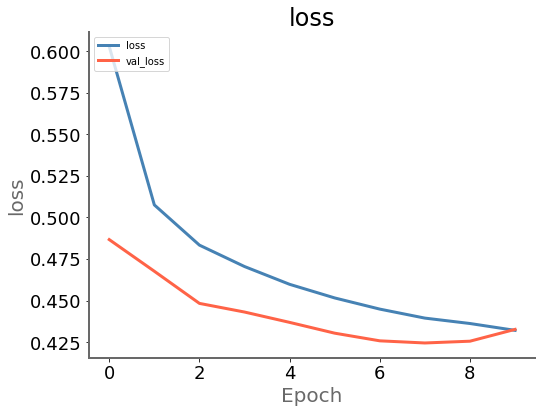

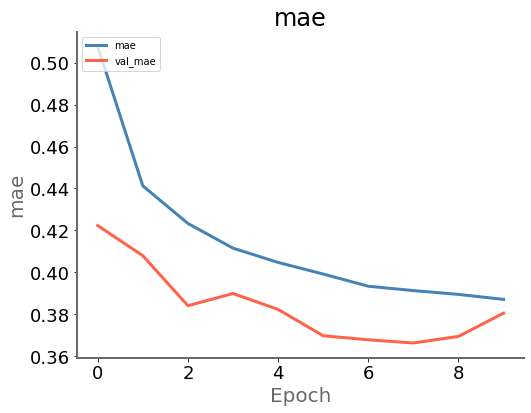

In [10]:
pwk.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

## Step 5 - Predict

### 5.1 - Load model

In [11]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

### 5.2 Make a prediction
A basic prediction, with normalized values (so humanly not very understandable)

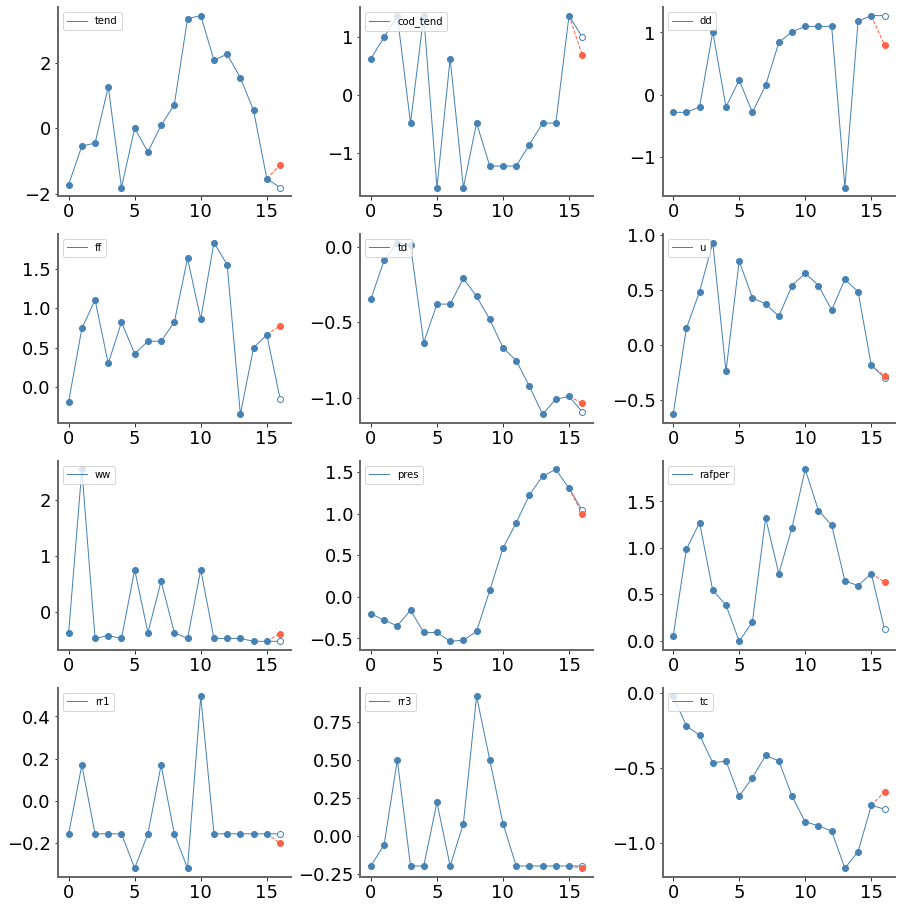

In [12]:
s=random.randint(0,len(dataset_test)-sequence_len)

sequence      = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

pred = loaded_model.predict( np.array([sequence]) )

# ---- Show result
pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm')


### 5.3 Real prediction
We are now going to make a true prediction, with an un-normalized result

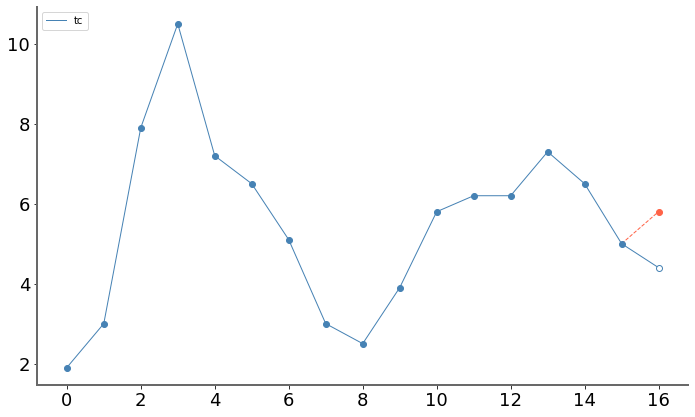

Gap between prediction and reality : 1.40 °C


In [13]:
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]

# ---- Prediction

pred = loaded_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

# ---- Show it
feat=11

pwk.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8, save_as='03-prediction')

delta_deg=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta_deg:.2f} °C')


In [14]:
pwk.end()

End time is : Tuesday 09 March 2021, 22:38:00
Duration is : 00:02:08 328ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>